# Import modules

In [1]:
import csv
import os
import pickle
import pytz
import torch
import timeit
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from copy import deepcopy
from datetime import datetime
from einops import rearrange
from itertools import chain
from time import time
from torch import nn, optim
from torchmetrics.classification import MulticlassAccuracy, MulticlassF1Score, MulticlassConfusionMatrix
from torch.optim import lr_scheduler
from tqdm.notebook import tqdm
from torch.utils.data import TensorDataset, DataLoader
from polyglot.mapping import Embedding, CaseExpander, DigitExpander

# Hyperparameters

In [2]:
class Hyperparams:
     def __init__(
        self,
        context_size=65,
        fold=3,
        max_seq_len=82,
        input_size=64,
        batch_size=32,
        num_hidden_layer=1,
        hidden_size=128,
        dropout=0,
        bias=True,
        output_size=24,
        shuffle=True,
        lr=0.005,
        batch_first=False,
        bidirectional=True,
        init_wb_with_kaiming_normal=True,
        n_epoch=50,
        patience=50,
        device="cuda" if torch.cuda.is_available() else "cpu"
    ):
        self.context_size = context_size
        self.fold = fold
        self.input_size = input_size
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.num_hidden_layer = num_hidden_layer
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.output_size = output_size
        self.shuffle = shuffle
        self.lr = lr
        self.batch_first = batch_first
        self.bidirectional = bidirectional
        self.init_wb_with_kaiming_normal = init_wb_with_kaiming_normal
        self.n_epoch = n_epoch
        self.patience = patience
        self.device = device

hyperparams = Hyperparams()

# Dataset

In [3]:
id_pos_tag = pd.read_csv("../../../datasets/raw/Indonesian_Manually_Tagged_Corpus.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False) 
train = pd.read_csv(f"../../../datasets/raw/cv/train/train.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
val = pd.read_csv(f"../../../datasets/raw/cv/val/val.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)
test = pd.read_csv(f"../../../datasets/raw/cv/test/test.0{hyperparams.fold}.tsv", sep="\t", header=None, names=["token", "tag"], quoting=csv.QUOTE_NONE, skip_blank_lines=False)

# Pre-trained Word Embedding

In [4]:
embeddings = Embedding.load("../../../word_embeddings/polyglot/idn_embeddings.tar.bz2")
embeddings.apply_expansion(DigitExpander)
embeddings.apply_expansion(CaseExpander)

oov_embeddings = pickle.load(open(f"../../../logs/comick/{hyperparams.context_size}_contexts/10-11-2022_17-31-59/oov_embedding_dict.pkl", "rb"))

# Data Preprocessing

## Add OOV Flag

In [5]:
def add_oov_flag(tokens, embeddings):
    oov_flags = []
    
    for token in tqdm(tokens):
        try:
            if token not in embeddings:
                oov_flags.append(True)
            else:
                oov_flags.append(False)
        except:
            oov_flags.append(False)
        
    return pd.DataFrame(oov_flags, columns=["is_oov"])

id_pos_tag_oov_flags = add_oov_flag(id_pos_tag["token"].values, embeddings)
train_oov_flags = add_oov_flag(train["token"].values, embeddings)
val_oov_flags = add_oov_flag(val["token"].values, embeddings)
test_oov_flags = add_oov_flag(test["token"].values, embeddings)

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

## Concate OOV Flag

In [6]:
id_pos_tag_df = pd.concat([id_pos_tag, id_pos_tag_oov_flags], axis=1)
train_df = pd.concat([train, train_oov_flags], axis=1)
val_df = pd.concat([val, val_oov_flags], axis=1)
test_df = pd.concat([test, test_oov_flags], axis=1)

## Lowercase OOV Token

In [7]:
id_pos_tag_df['token'] = np.where(id_pos_tag_df['is_oov'] == True, id_pos_tag_df['token'].str.lower(), id_pos_tag_df['token'])
train_df['token'] = np.where(train_df['is_oov'] == True, train_df['token'].str.lower(), train_df['token'])
val_df['token'] = np.where(val_df['is_oov'] == True, val_df['token'].str.lower(), val_df['token'])
test_df['token'] = np.where(test_df['is_oov'] == True, test_df['token'].str.lower(), test_df['token'])

## Embedding Dict, Index to Token and Token to Index

In [8]:
tokens = list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None))

def embedding_dict(tokens, embeddings, oov_embeddings):
    embedding = {}
    
    for token in tokens:
        if token[0] is not np.nan:
            if token[2] == False or token[0] in embeddings:
                embedding[token[0]] = embeddings[token[0]]
            else:
                embedding[token[0]] = oov_embeddings[token[0].lower()]

    return embedding

embedding_dict = embedding_dict(tokens, embeddings, oov_embeddings)
embedding_dict["<PAD>"] = embeddings["<PAD>"]
word_embeddings = nn.Embedding.from_pretrained(torch.FloatTensor(np.array(list(embedding_dict.values()))), padding_idx=list(embedding_dict.keys()).index("<PAD>"), freeze=True)

idx_to_token = {idx: token for idx, token in enumerate(list(embedding_dict.keys()))}
token_to_idx = {token: idx for idx, token in enumerate(list(embedding_dict.keys()))}

## Token to Sentence

In [9]:
def make_sentence(tokens, max_length_sentence=hyperparams.max_seq_len):
    sentence = []
    sentences = []

    for token in tqdm(tokens):
        if token[0] is not np.nan:
            sentence.append(token)
        else:
            sentences.append(sentence[:max_length_sentence])
            sentence = []

    return sentences

all_sentence = make_sentence(list(id_pos_tag_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
train_sentences = make_sentence(list(train_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
val_sentences = make_sentence(list(test_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))
test_sentences = make_sentence(list(val_df[["token", "tag", "is_oov"]].itertuples(index=False, name=None)))

  0%|          | 0/266652 [00:00<?, ?it/s]

  0%|          | 0/192215 [00:00<?, ?it/s]

  0%|          | 0/53294 [00:00<?, ?it/s]

  0%|          | 0/21143 [00:00<?, ?it/s]

## Word Token, Padding, and Word token to Index 

In [10]:
def tokenize_docs(docs, idx_token):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token[idx_token])
        sentences.append(new_sentence)
        new_sentence = []

    return sentences

def padding(docs, max_seq_len=hyperparams.max_seq_len, mode="post", val_pad="<PAD>"):
    docs = deepcopy(docs)
    doc_with_pad = []
    docs_with_pad = []

    for doc in tqdm(docs):
        if mode == "pre":
            for _ in range(max_seq_len - len(doc)):
                doc.insert(0, val_pad)
        elif mode == "post":
            for _ in range(max_seq_len - len(doc)):
                doc.append(val_pad)
        else:
            return f"Mode {mode} is not available, use instead 'pre' or 'post'."
        
        docs_with_pad.append(doc)
        
    return np.array(docs_with_pad)

def sent_to_idx(docs, token_to_idx):
    new_sentence = []
    sentences = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            new_sentence.append(token_to_idx[token])
        sentences.append(new_sentence)
        new_sentence = []

    return np.array(sentences)

def convert_feature_to_idx(docs, idx_token, token_to_idx, max_seq_len):
    sentences = tokenize_docs(docs, idx_token)
    sentences_with_pad = padding(sentences, max_seq_len=max_seq_len, mode="post", val_pad="<PAD>")
    sentences_to_idx = sent_to_idx(sentences_with_pad, token_to_idx)
    
    return sentences_to_idx

train_sentence_idxs = convert_feature_to_idx(train_sentences, 0, token_to_idx, hyperparams.max_seq_len)
val_sentence_idxs = convert_feature_to_idx(val_sentences, 0, token_to_idx, hyperparams.max_seq_len)
test_sentence_idxs = convert_feature_to_idx(test_sentences, 0, token_to_idx, hyperparams.max_seq_len)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

## Encode Class

In [11]:
classes = sorted(np.delete(id_pos_tag_df["tag"].unique(), 3))
idx_to_label = {idx: label for idx, label in enumerate(classes + ["<PAD>"])}
label_to_idx = {label: idx for idx, label in enumerate(classes + ["<PAD>"])}

def encode_class(docs, label_to_idx, seq_len=hyperparams.max_seq_len):
    class_idxs = []
    classes = []
    
    for sentence in tqdm(docs):
        for token in sentence:
            class_idxs.append(label_to_idx[token[1]])
            
        for _ in range(seq_len - len(sentence)):
            class_idxs.append(label_to_idx["<PAD>"])
                
        classes.append(class_idxs)
        class_idxs = []

    return np.array(classes)
        
train_class_idxs = encode_class(train_sentences, label_to_idx)
val_class_idxs = encode_class(val_sentences, label_to_idx)
test_class_idxs = encode_class(test_sentences, label_to_idx)

print(f"Training shape   : {train_sentence_idxs.shape, train_class_idxs.shape}")
print(f"validation shape : {val_class_idxs.shape, val_class_idxs.shape}")
print(f"Test shape       : {test_sentence_idxs.shape, test_class_idxs.shape}")

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

Training shape   : ((7222, 82), (7222, 82))
validation shape : ((2006, 82), (2006, 82))
Test shape       : ((802, 82), (802, 82))


## Note

- Number of sentences = 10030
- Train : 72% (7222)
- Val   : 8% (802)
- Test  : 20% (2006)

# Build Model

## Feature and Actual Class

In [12]:
train_feature = torch.LongTensor(train_sentence_idxs)
val_feature = torch.LongTensor(val_sentence_idxs)
test_feature = torch.LongTensor(test_sentence_idxs)

train_class = torch.LongTensor(train_class_idxs)
val_class = torch.LongTensor(val_class_idxs)
test_class = torch.LongTensor(test_class_idxs)

In [13]:
train_feature.shape, val_feature.shape, test_feature.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

In [14]:
train_class.shape, val_class.shape, test_class.shape

(torch.Size([7222, 82]), torch.Size([2006, 82]), torch.Size([802, 82]))

## Tensor Dataset

In [15]:
train_dataset = TensorDataset(train_feature, train_class)
val_dataset = TensorDataset(val_feature, val_class)
test_dataset = TensorDataset(test_feature, test_class)

## Dataloader

In [16]:
train_dataloader = DataLoader(train_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
val_dataloader = DataLoader(val_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)
test_dataloader = DataLoader(test_dataset, batch_size=hyperparams.batch_size, shuffle=hyperparams.shuffle)

## Model

In [17]:
class POSTagger(nn.Module):
    def __init__(
        self,
        input_size=hyperparams.input_size,
        hidden_size=hyperparams.hidden_size,
        dropout=hyperparams.dropout,
        bias=hyperparams.bias,
        num_layers=hyperparams.num_hidden_layer,
        output_size=hyperparams.output_size,
        batch_first=hyperparams.batch_first,
        bidirectional=hyperparams.bidirectional,
        init_wb_with_kaiming_normal=hyperparams.init_wb_with_kaiming_normal
    ):
        super(POSTagger, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.bias = bias
        self.num_layers = num_layers
        self.output_size = output_size
        self.batch_first = batch_first
        self.bidirectional = bidirectional
                
        self.feature = nn.LSTM(
            input_size = self.input_size,
            hidden_size = self.hidden_size,
            bias = self.bias,
            dropout = self.dropout,
            num_layers = self.num_layers,
            batch_first = self.batch_first,
            bidirectional = self.bidirectional
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(in_features=2 * self.hidden_size if hyperparams.bidirectional else self.hidden_size, out_features=self.output_size, bias=self.bias),
            nn.Softmax(dim=-1)
        )
        
        if init_wb_with_kaiming_normal:
            self.init_wb()

    def init_wb(self):
        for module in self.modules():
            if isinstance(module, (nn.Linear, nn.LSTM)):
                for name, param in module.named_parameters():
                    if "weight" in name:
                        nn.init.kaiming_normal_(param)
                    else:
                        nn.init.kaiming_normal_(param.reshape(1, -1))
        
    def forward(self, feature, hidden=None):
        output, (hidden, memory) = self.feature(feature, None)
        prob = self.classifier(output)

        return prob
    
model = POSTagger().to(hyperparams.device)
model

POSTagger(
  (feature): LSTM(64, 128, bidirectional=True)
  (classifier): Sequential(
    (0): Linear(in_features=256, out_features=24, bias=True)
    (1): Softmax(dim=-1)
  )
)

## Optimizer, Criterion, and Metric

In [18]:
optimizer = optim.Adam(model.parameters(), lr=hyperparams.lr)
criterion = nn.CrossEntropyLoss().to(hyperparams.device)
train_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="global", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", verbose=True, factor=0.5)

In [19]:
sum(param.numel() for param in model.parameters() if param.requires_grad)

204824

## Training Step

In [20]:
def training_step(dataloader, model, optimizer, criterion, metric, scheduler=None):
    model.train()
    
    batch_losses = []
    batch_metric_scores = []
    
    for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
        # Forward Propagation
        feature = rearrange(feature, "n s -> s n")
        actual_label = rearrange(actual_label, "n s -> s n")
        embedding = word_embeddings(feature)
        
        prob = model(
            embedding.to(hyperparams.device),
            actual_label.to(hyperparams.device)
        )
        
        prob = prob.reshape(-1, prob.shape[-1])
        actual_label = actual_label.reshape(-1)

        loss = criterion(prob, actual_label.to(hyperparams.device))
        metric_score = metric(prob, actual_label.to(hyperparams.device))
        metric_score = metric.compute()
                
        if scheduler is not None:
            scheduler.step(loss)
        
        batch_losses.append(loss.item())
        batch_metric_scores.append(metric_score)
        
        if len(dataloader) < 10:
            if batch % 1 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
        else:
            if batch % 15 == 0 or batch == len(dataloader):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            
        # Backward Propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    return batch_losses, batch_metric_scores

## Validation Step

In [21]:
def validation_step(dataloader, model, criterion, metric):
    model.eval()
    
    batch_losses = []
    batch_metric_scores = []
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob, actual_label.to(hyperparams.device))
            metric_score = metric.compute()

            batch_losses.append(loss.item())
            batch_metric_scores.append(metric_score)
            
            if len(dataloader) < 10 and (batch % 1 == 0 or batch == len(dataloader)):
                batch_name = "Batch-" + str(batch)
                print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                    f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
            else:
                if batch % 15 == 0 or batch == len(dataloader):
                    batch_name = "Batch-" + str(batch)
                    print(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}")
                    with open(f"../../../logs/classifier/{hyperparams.context_size}_contexts/{root_path}/training_history.txt", "a") as f:
                        f.write(f"{batch_name.ljust(9)}: {str(criterion).split('(')[0]}={(loss.item()):.4f} | {str(metric).split('(')[0]}={(metric_score):.4f}\n")
    
    return batch_losses, batch_metric_scores

## Looping Step

EPOCH-1
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.4958 | MulticlassF1Score=0.1678
Batch-30 : CrossEntropyLoss=2.5093 | MulticlassF1Score=0.2126
Batch-45 : CrossEntropyLoss=2.4587 | MulticlassF1Score=0.2288
Batch-60 : CrossEntropyLoss=2.4867 | MulticlassF1Score=0.2355
Batch-75 : CrossEntropyLoss=2.4366 | MulticlassF1Score=0.2500
Batch-90 : CrossEntropyLoss=2.4367 | MulticlassF1Score=0.2683
Batch-105: CrossEntropyLoss=2.4233 | MulticlassF1Score=0.2885
Batch-120: CrossEntropyLoss=2.4044 | MulticlassF1Score=0.3145
Batch-135: CrossEntropyLoss=2.3883 | MulticlassF1Score=0.3435
Batch-150: CrossEntropyLoss=2.3794 | MulticlassF1Score=0.3672
Batch-165: CrossEntropyLoss=2.3785 | MulticlassF1Score=0.3868
Batch-180: CrossEntropyLoss=2.3759 | MulticlassF1Score=0.4032
Batch-195: CrossEntropyLoss=2.3625 | MulticlassF1Score=0.4183
Batch-210: CrossEntropyLoss=2.3602 | MulticlassF1Score=0.4347
Batch-225: CrossEntropyLoss=2.3468 | MulticlassF1Score=0.4500
Batch-226: CrossEntropyLoss=2.3418 | MulticlassF1Score=0.4508

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3646 | MulticlassF1Score=0.6760
Batch-30 : CrossEntropyLoss=2.3536 | MulticlassF1Score=0.6747
Batch-45 : CrossEntropyLoss=2.3484 | MulticlassF1Score=0.6756
Batch-60 : CrossEntropyLoss=2.3336 | MulticlassF1Score=0.6742
Batch-63 : CrossEntropyLoss=2.3576 | MulticlassF1Score=0.6745

Training   : Mean CrossEntropyLoss = 2.4292 | Mean MulticlassF1Score = 0.3073
Validation : Mean CrossEntropyLoss = 2.3495 | Mean MulticlassF1Score = 0.6762

EPOCH-2
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3270 | MulticlassF1Score=0.6971
Batch-30 : CrossEntropyLoss=2.3291 | MulticlassF1Score=0.7033
Batch-45 : CrossEntropyLoss=2.3315 | MulticlassF1Score=0.7053
Batch-60 : CrossEntropyLoss=2.3376 | MulticlassF1Score=0.7105
Batch-75 : CrossEntropyLoss=2.3337 | MulticlassF1Score=0.7135
Batch-90 : CrossEntropyLoss=2.3260 | MulticlassF1Score=0.7146
Batch-105: CrossEntropyLoss=2.3368 | MulticlassF1Score=0.7153
Batch-120: CrossEntropyLoss=2.3338 | MulticlassF1Score=0.7150
Batch-135: CrossEntropyLoss=2.3342 | MulticlassF1Score=0.7158
Batch-150: CrossEntropyLoss=2.3447 | MulticlassF1Score=0.7160
Batch-165: CrossEntropyLoss=2.3330 | MulticlassF1Score=0.7165
Batch-180: CrossEntropyLoss=2.3407 | MulticlassF1Score=0.7175
Batch-195: CrossEntropyLoss=2.3321 | MulticlassF1Score=0.7176
Batch-210: CrossEntropyLoss=2.3361 | MulticlassF1Score=0.7185
Batch-225: CrossEntropyLoss=2.3247 | MulticlassF1Score=0.7190
Batch-226: CrossEntropyLoss=2.3358 | MulticlassF1Score=0.7190

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3285 | MulticlassF1Score=0.7220
Batch-30 : CrossEntropyLoss=2.3412 | MulticlassF1Score=0.7264
Batch-45 : CrossEntropyLoss=2.3338 | MulticlassF1Score=0.7276
Batch-60 : CrossEntropyLoss=2.3334 | MulticlassF1Score=0.7266
Batch-63 : CrossEntropyLoss=2.3360 | MulticlassF1Score=0.7260

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3359 | Mean MulticlassF1Score = 0.7113
Validation : Mean CrossEntropyLoss = 2.3330 | Mean MulticlassF1Score = 0.7251

EPOCH-3
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3288 | MulticlassF1Score=0.7334
Batch-30 : CrossEntropyLoss=2.3473 | MulticlassF1Score=0.7278
Batch-45 : CrossEntropyLoss=2.3244 | MulticlassF1Score=0.7287
Batch-60 : CrossEntropyLoss=2.3194 | MulticlassF1Score=0.7340
Batch-75 : CrossEntropyLoss=2.3314 | MulticlassF1Score=0.7411
Batch-90 : CrossEntropyLoss=2.3202 | MulticlassF1Score=0.7462
Batch-105: CrossEntropyLoss=2.3183 | MulticlassF1Score=0.7517
Batch-120: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.7564
Batch-135: CrossEntropyLoss=2.2992 | MulticlassF1Score=0.7600
Batch-150: CrossEntropyLoss=2.3082 | MulticlassF1Score=0.7637
Batch-165: CrossEntropyLoss=2.3172 | MulticlassF1Score=0.7667
Batch-180: CrossEntropyLoss=2.3130 | MulticlassF1Score=0.7686
Batch-195: CrossEntropyLoss=2.3089 | MulticlassF1Score=0.7707
Batch-210: CrossEntropyLoss=2.3069 | MulticlassF1Score=0.7725
Batch-225: CrossEntropyLoss=2.3186 | MulticlassF1Score=0.7742
Batch-226: CrossEntropyLoss=2.3199 | MulticlassF1Score=0.7743

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3051 | MulticlassF1Score=0.7978
Batch-30 : CrossEntropyLoss=2.3116 | MulticlassF1Score=0.7967
Batch-45 : CrossEntropyLoss=2.3192 | MulticlassF1Score=0.7955
Batch-60 : CrossEntropyLoss=2.3195 | MulticlassF1Score=0.7941
Batch-63 : CrossEntropyLoss=2.3078 | MulticlassF1Score=0.7948

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3183 | Mean MulticlassF1Score = 0.7518
Validation : Mean CrossEntropyLoss = 2.3115 | Mean MulticlassF1Score = 0.7973

EPOCH-4
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3091 | MulticlassF1Score=0.7963
Batch-30 : CrossEntropyLoss=2.3129 | MulticlassF1Score=0.7963
Batch-45 : CrossEntropyLoss=2.3070 | MulticlassF1Score=0.7987
Batch-60 : CrossEntropyLoss=2.3171 | MulticlassF1Score=0.7972
Batch-75 : CrossEntropyLoss=2.3101 | MulticlassF1Score=0.7975
Batch-90 : CrossEntropyLoss=2.2998 | MulticlassF1Score=0.7991
Batch-105: CrossEntropyLoss=2.3142 | MulticlassF1Score=0.7978
Batch-120: CrossEntropyLoss=2.3025 | MulticlassF1Score=0.7977
Batch-135: CrossEntropyLoss=2.3201 | MulticlassF1Score=0.7963
Batch-150: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.7967
Batch-165: CrossEntropyLoss=2.3057 | MulticlassF1Score=0.7970
Batch-180: CrossEntropyLoss=2.3085 | MulticlassF1Score=0.7967
Batch-195: CrossEntropyLoss=2.2932 | MulticlassF1Score=0.7972
Batch-210: CrossEntropyLoss=2.3159 | MulticlassF1Score=0.7988
Batch-225: CrossEntropyLoss=2.3068 | MulticlassF1Score=0.8001
Batch-226: CrossEntropyLoss=2.2967 | MulticlassF1Score=0.8003

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3046 | MulticlassF1Score=0.8202
Batch-30 : CrossEntropyLoss=2.2995 | MulticlassF1Score=0.8197
Batch-45 : CrossEntropyLoss=2.3075 | MulticlassF1Score=0.8171
Batch-60 : CrossEntropyLoss=2.3092 | MulticlassF1Score=0.8166
Batch-63 : CrossEntropyLoss=2.3054 | MulticlassF1Score=0.8163

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3098 | Mean MulticlassF1Score = 0.7973
Validation : Mean CrossEntropyLoss = 2.3048 | Mean MulticlassF1Score = 0.8197

EPOCH-5
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8219
Batch-30 : CrossEntropyLoss=2.3049 | MulticlassF1Score=0.8144
Batch-45 : CrossEntropyLoss=2.3196 | MulticlassF1Score=0.8142
Batch-60 : CrossEntropyLoss=2.2989 | MulticlassF1Score=0.8170
Batch-75 : CrossEntropyLoss=2.2978 | MulticlassF1Score=0.8175
Batch-90 : CrossEntropyLoss=2.3007 | MulticlassF1Score=0.8202
Batch-105: CrossEntropyLoss=2.3088 | MulticlassF1Score=0.8220
Batch-120: CrossEntropyLoss=2.2903 | MulticlassF1Score=0.8229
Batch-135: CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8247
Batch-150: CrossEntropyLoss=2.2948 | MulticlassF1Score=0.8253
Batch-165: CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8256
Batch-180: CrossEntropyLoss=2.3106 | MulticlassF1Score=0.8260
Batch-195: CrossEntropyLoss=2.3045 | MulticlassF1Score=0.8261
Batch-210: CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8265
Batch-225: CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8264
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8264

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2970 | MulticlassF1Score=0.8326
Batch-30 : CrossEntropyLoss=2.2972 | MulticlassF1Score=0.8287
Batch-45 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8288
Batch-60 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8295
Batch-63 : CrossEntropyLoss=2.3094 | MulticlassF1Score=0.8289

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.3017 | Mean MulticlassF1Score = 0.8210
Validation : Mean CrossEntropyLoss = 2.3008 | Mean MulticlassF1Score = 0.8283

EPOCH-6
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8309
Batch-30 : CrossEntropyLoss=2.3041 | MulticlassF1Score=0.8322
Batch-45 : CrossEntropyLoss=2.3076 | MulticlassF1Score=0.8329
Batch-60 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8329
Batch-75 : CrossEntropyLoss=2.2908 | MulticlassF1Score=0.8323
Batch-90 : CrossEntropyLoss=2.3058 | MulticlassF1Score=0.8320
Batch-105: CrossEntropyLoss=2.2999 | MulticlassF1Score=0.8318
Batch-120: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8315
Batch-135: CrossEntropyLoss=2.3118 | MulticlassF1Score=0.8320
Batch-150: CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8320
Batch-165: CrossEntropyLoss=2.3044 | MulticlassF1Score=0.8320
Batch-180: CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8317
Batch-195: CrossEntropyLoss=2.3067 | MulticlassF1Score=0.8311
Batch-210: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8314
Batch-225: CrossEntropyLoss=2.3006 | MulticlassF1Score=0.8318
Batch-226: CrossEntropyLoss=2.2938 | MulticlassF1Score=0.8318

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3019 | MulticlassF1Score=0.8266
Batch-30 : CrossEntropyLoss=2.3039 | MulticlassF1Score=0.8275
Batch-45 : CrossEntropyLoss=2.3021 | MulticlassF1Score=0.8291
Batch-60 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8303
Batch-63 : CrossEntropyLoss=2.2956 | MulticlassF1Score=0.8301

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2998 | Mean MulticlassF1Score = 0.8320
Validation : Mean CrossEntropyLoss = 2.3002 | Mean MulticlassF1Score = 0.8295

EPOCH-7
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2960 | MulticlassF1Score=0.8350
Batch-30 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8384
Batch-45 : CrossEntropyLoss=2.2959 | MulticlassF1Score=0.8385
Batch-60 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8409
Batch-75 : CrossEntropyLoss=2.2920 | MulticlassF1Score=0.8418
Batch-90 : CrossEntropyLoss=2.2906 | MulticlassF1Score=0.8431
Batch-105: CrossEntropyLoss=2.2997 | MulticlassF1Score=0.8434
Batch-120: CrossEntropyLoss=2.2907 | MulticlassF1Score=0.8445
Batch-135: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8450
Batch-150: CrossEntropyLoss=2.3034 | MulticlassF1Score=0.8455
Batch-165: CrossEntropyLoss=2.3062 | MulticlassF1Score=0.8460
Batch-180: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8464
Batch-195: CrossEntropyLoss=2.2969 | MulticlassF1Score=0.8466
Batch-210: CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8468
Batch-225: CrossEntropyLoss=2.2968 | MulticlassF1Score=0.8466
Batch-226: CrossEntropyLoss=2.2857 | MulticlassF1Score=0.8466

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2954 | MulticlassF1Score=0.8472
Batch-30 : CrossEntropyLoss=2.2936 | MulticlassF1Score=0.8470
Batch-45 : CrossEntropyLoss=2.2945 | MulticlassF1Score=0.8466
Batch-60 : CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8466
Batch-63 : CrossEntropyLoss=2.2986 | MulticlassF1Score=0.8464

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2955 | Mean MulticlassF1Score = 0.8427
Validation : Mean CrossEntropyLoss = 2.2954 | Mean MulticlassF1Score = 0.8458

EPOCH-8
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3031 | MulticlassF1Score=0.8539
Batch-30 : CrossEntropyLoss=2.2975 | MulticlassF1Score=0.8494
Batch-45 : CrossEntropyLoss=2.2931 | MulticlassF1Score=0.8496
Batch-60 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8516
Batch-75 : CrossEntropyLoss=2.2891 | MulticlassF1Score=0.8518
Batch-90 : CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8524
Batch-105: CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8520
Batch-120: CrossEntropyLoss=2.2951 | MulticlassF1Score=0.8520
Batch-135: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8522
Batch-150: CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8527
Batch-165: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8525
Batch-180: CrossEntropyLoss=2.3026 | MulticlassF1Score=0.8520
Batch-195: CrossEntropyLoss=2.2961 | MulticlassF1Score=0.8517
Batch-210: CrossEntropyLoss=2.2957 | MulticlassF1Score=0.8516
Batch-225: CrossEntropyLoss=2.2934 | MulticlassF1Score=0.8518
Batch-226: CrossEntropyLoss=2.2952 | MulticlassF1Score=0.8518

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2851 | MulticlassF1Score=0.8466
Batch-30 : CrossEntropyLoss=2.2901 | MulticlassF1Score=0.8495
Batch-45 : CrossEntropyLoss=2.2963 | MulticlassF1Score=0.8491
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8478
Batch-63 : CrossEntropyLoss=2.2977 | MulticlassF1Score=0.8475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2938 | Mean MulticlassF1Score = 0.8520
Validation : Mean CrossEntropyLoss = 2.2950 | Mean MulticlassF1Score = 0.8485

EPOCH-9
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2979 | MulticlassF1Score=0.8485
Batch-30 : CrossEntropyLoss=2.2840 | MulticlassF1Score=0.8536
Batch-45 : CrossEntropyLoss=2.2898 | MulticlassF1Score=0.8535
Batch-60 : CrossEntropyLoss=2.2937 | MulticlassF1Score=0.8515
Batch-75 : CrossEntropyLoss=2.2868 | MulticlassF1Score=0.8523
Batch-90 : CrossEntropyLoss=2.2871 | MulticlassF1Score=0.8517
Batch-105: CrossEntropyLoss=2.2916 | MulticlassF1Score=0.8519
Batch-120: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8521
Batch-135: CrossEntropyLoss=2.2913 | MulticlassF1Score=0.8527
Batch-150: CrossEntropyLoss=2.2886 | MulticlassF1Score=0.8528
Batch-165: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8528
Batch-180: CrossEntropyLoss=2.2909 | MulticlassF1Score=0.8528
Batch-195: CrossEntropyLoss=2.2991 | MulticlassF1Score=0.8529
Batch-210: CrossEntropyLoss=2.2981 | MulticlassF1Score=0.8534
Batch-225: CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8534
Batch-226: CrossEntropyLoss=2.3079 | MulticlassF1Score=0.8533

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2924 | MulticlassF1Score=0.8478
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8465
Batch-45 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8480
Batch-60 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8475
Batch-63 : CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8476

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2932 | Mean MulticlassF1Score = 0.8527
Validation : Mean CrossEntropyLoss = 2.2948 | Mean MulticlassF1Score = 0.8468

EPOCH-10
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2875 | MulticlassF1Score=0.8494
Batch-30 : CrossEntropyLoss=2.2902 | MulticlassF1Score=0.8506
Batch-45 : CrossEntropyLoss=2.2880 | MulticlassF1Score=0.8496
Batch-60 : CrossEntropyLoss=2.2987 | MulticlassF1Score=0.8503
Batch-75 : CrossEntropyLoss=2.2884 | MulticlassF1Score=0.8528
Batch-90 : CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8540
Batch-105: CrossEntropyLoss=2.2899 | MulticlassF1Score=0.8551
Batch-120: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8558
Batch-135: CrossEntropyLoss=2.2910 | MulticlassF1Score=0.8575
Batch-150: CrossEntropyLoss=2.2953 | MulticlassF1Score=0.8579
Batch-165: CrossEntropyLoss=2.2877 | MulticlassF1Score=0.8586
Batch-180: CrossEntropyLoss=2.2862 | MulticlassF1Score=0.8595
Batch-195: CrossEntropyLoss=2.2843 | MulticlassF1Score=0.8599
Batch-210: CrossEntropyLoss=2.2917 | MulticlassF1Score=0.8604
Batch-225: CrossEntropyLoss=2.2921 | MulticlassF1Score=0.8605
Batch-226: CrossEntropyLoss=2.2872 | MulticlassF1Score=0.8606

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.3005 | MulticlassF1Score=0.8574
Batch-30 : CrossEntropyLoss=2.2896 | MulticlassF1Score=0.8574
Batch-45 : CrossEntropyLoss=2.2935 | MulticlassF1Score=0.8568
Batch-60 : CrossEntropyLoss=2.2958 | MulticlassF1Score=0.8575
Batch-63 : CrossEntropyLoss=2.2918 | MulticlassF1Score=0.8574

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2908 | Mean MulticlassF1Score = 0.8548
Validation : Mean CrossEntropyLoss = 2.2919 | Mean MulticlassF1Score = 0.8583

EPOCH-11
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2974 | MulticlassF1Score=0.8602
Batch-30 : CrossEntropyLoss=2.2914 | MulticlassF1Score=0.8632
Batch-45 : CrossEntropyLoss=2.2973 | MulticlassF1Score=0.8629
Batch-60 : CrossEntropyLoss=2.2925 | MulticlassF1Score=0.8637
Batch-75 : CrossEntropyLoss=2.2962 | MulticlassF1Score=0.8658
Batch-90 : CrossEntropyLoss=2.2842 | MulticlassF1Score=0.8692
Batch-105: CrossEntropyLoss=2.2764 | MulticlassF1Score=0.8727
Batch-120: CrossEntropyLoss=2.2894 | MulticlassF1Score=0.8750
Batch-135: CrossEntropyLoss=2.2817 | MulticlassF1Score=0.8772
Batch-150: CrossEntropyLoss=2.2858 | MulticlassF1Score=0.8785
Batch-165: CrossEntropyLoss=2.2834 | MulticlassF1Score=0.8797
Batch-180: CrossEntropyLoss=2.2771 | MulticlassF1Score=0.8805
Batch-195: CrossEntropyLoss=2.2808 | MulticlassF1Score=0.8816
Batch-210: CrossEntropyLoss=2.2823 | MulticlassF1Score=0.8823
Batch-225: CrossEntropyLoss=2.2818 | MulticlassF1Score=0.8830
Batch-226: CrossEntropyLoss=2.2800 | MulticlassF1Score=0.8830

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2881 | MulticlassF1Score=0.8914
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.8892
Batch-45 : CrossEntropyLoss=2.2887 | MulticlassF1Score=0.8872
Batch-60 : CrossEntropyLoss=2.2824 | MulticlassF1Score=0.8874
Batch-63 : CrossEntropyLoss=2.2833 | MulticlassF1Score=0.8877

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2842 | Mean MulticlassF1Score = 0.8722
Validation : Mean CrossEntropyLoss = 2.2827 | Mean MulticlassF1Score = 0.8897

EPOCH-12
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8919
Batch-30 : CrossEntropyLoss=2.2789 | MulticlassF1Score=0.8930
Batch-45 : CrossEntropyLoss=2.2806 | MulticlassF1Score=0.8921
Batch-60 : CrossEntropyLoss=2.2781 | MulticlassF1Score=0.8932
Batch-75 : CrossEntropyLoss=2.2839 | MulticlassF1Score=0.8934
Batch-90 : CrossEntropyLoss=2.2784 | MulticlassF1Score=0.8943
Batch-105: CrossEntropyLoss=2.2746 | MulticlassF1Score=0.8945
Batch-120: CrossEntropyLoss=2.2734 | MulticlassF1Score=0.8944
Batch-135: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.8951
Batch-150: CrossEntropyLoss=2.2826 | MulticlassF1Score=0.8952
Batch-165: CrossEntropyLoss=2.2809 | MulticlassF1Score=0.8952
Batch-180: CrossEntropyLoss=2.2714 | MulticlassF1Score=0.8955
Batch-195: CrossEntropyLoss=2.2745 | MulticlassF1Score=0.8971
Batch-210: CrossEntropyLoss=2.2708 | MulticlassF1Score=0.8988
Batch-225: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9005
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9006

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9169
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9164
Batch-45 : CrossEntropyLoss=2.2776 | MulticlassF1Score=0.9150
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9145
Batch-63 : CrossEntropyLoss=2.2766 | MulticlassF1Score=0.9145

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2788 | Mean MulticlassF1Score = 0.8949
Validation : Mean CrossEntropyLoss = 2.2747 | Mean MulticlassF1Score = 0.9164

EPOCH-13
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9256
Batch-30 : CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9244
Batch-45 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9245
Batch-60 : CrossEntropyLoss=2.2746 | MulticlassF1Score=0.9243
Batch-75 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9250
Batch-90 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9257
Batch-105: CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9250
Batch-120: CrossEntropyLoss=2.2755 | MulticlassF1Score=0.9255
Batch-135: CrossEntropyLoss=2.2761 | MulticlassF1Score=0.9255
Batch-150: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9254
Batch-165: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9255
Batch-180: CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9256
Batch-195: CrossEntropyLoss=2.2756 | MulticlassF1Score=0.9253
Batch-210: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9250
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9252
Batch-226: CrossEntropyLoss=2.2704 | MulticlassF1Score=0.9252

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2741 | MulticlassF1Score=0.9177
Batch-30 : CrossEntropyLoss=2.2809 | MulticlassF1Score=0.9181
Batch-45 : CrossEntropyLoss=2.2743 | MulticlassF1Score=0.9189
Batch-60 : CrossEntropyLoss=2.2763 | MulticlassF1Score=0.9179
Batch-63 : CrossEntropyLoss=2.2783 | MulticlassF1Score=0.9174

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2712 | Mean MulticlassF1Score = 0.9253
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9188

EPOCH-14
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9299
Batch-30 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9261
Batch-45 : CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9271
Batch-60 : CrossEntropyLoss=2.2716 | MulticlassF1Score=0.9278
Batch-75 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9278
Batch-90 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9284
Batch-105: CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9286
Batch-120: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9279
Batch-135: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9280
Batch-150: CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9280
Batch-165: CrossEntropyLoss=2.2720 | MulticlassF1Score=0.9271
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9269
Batch-195: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9269
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9271
Batch-225: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9270
Batch-226: CrossEntropyLoss=2.2740 | MulticlassF1Score=0.9270

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2701 | MulticlassF1Score=0.9202
Batch-30 : CrossEntropyLoss=2.2787 | MulticlassF1Score=0.9199
Batch-45 : CrossEntropyLoss=2.2731 | MulticlassF1Score=0.9183
Batch-60 : CrossEntropyLoss=2.2739 | MulticlassF1Score=0.9175
Batch-63 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9170

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2704 | Mean MulticlassF1Score = 0.9275
Validation : Mean CrossEntropyLoss = 2.2734 | Mean MulticlassF1Score = 0.9181

EPOCH-15
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9264
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9294
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9289
Batch-60 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9297
Batch-75 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9299
Batch-90 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9296
Batch-105: CrossEntropyLoss=2.2738 | MulticlassF1Score=0.9294
Batch-120: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9286
Batch-135: CrossEntropyLoss=2.2777 | MulticlassF1Score=0.9287
Batch-150: CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9286
Batch-165: CrossEntropyLoss=2.2726 | MulticlassF1Score=0.9287
Batch-180: CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9287
Batch-195: CrossEntropyLoss=2.2681 | MulticlassF1Score=0.9288
Batch-210: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9287
Batch-225: CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9285
Batch-226: CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9285

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2691 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9165
Batch-45 : CrossEntropyLoss=2.2744 | MulticlassF1Score=0.9156
Batch-60 : CrossEntropyLoss=2.2758 | MulticlassF1Score=0.9167
Batch-63 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9169

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2699 | Mean MulticlassF1Score = 0.9288
Validation : Mean CrossEntropyLoss = 2.2735 | Mean MulticlassF1Score = 0.9156

EPOCH-16
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9311
Batch-30 : CrossEntropyLoss=2.2811 | MulticlassF1Score=0.9287
Batch-45 : CrossEntropyLoss=2.2751 | MulticlassF1Score=0.9283
Batch-60 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9295
Batch-75 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9295
Batch-90 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9291
Batch-105: CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9300
Batch-120: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9306
Batch-135: CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9308
Batch-150: CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9310
Batch-165: CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9315
Batch-180: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9316
Batch-195: CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9318
Batch-210: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9319
Batch-225: CrossEntropyLoss=2.2703 | MulticlassF1Score=0.9320
Batch-226: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9320

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9180
Batch-30 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9192
Batch-45 : CrossEntropyLoss=2.2719 | MulticlassF1Score=0.9204
Batch-60 : CrossEntropyLoss=2.2686 | MulticlassF1Score=0.9209
Batch-63 : CrossEntropyLoss=2.2737 | MulticlassF1Score=0.9210

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2688 | Mean MulticlassF1Score = 0.9303
Validation : Mean CrossEntropyLoss = 2.2722 | Mean MulticlassF1Score = 0.9186

EPOCH-17
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2688 | MulticlassF1Score=0.9375
Batch-30 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9363
Batch-45 : CrossEntropyLoss=2.2729 | MulticlassF1Score=0.9364
Batch-60 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9358
Batch-75 : CrossEntropyLoss=2.2672 | MulticlassF1Score=0.9351
Batch-90 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9348
Batch-105: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9351
Batch-120: CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9353
Batch-135: CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9350
Batch-150: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9349
Batch-165: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9351
Batch-180: CrossEntropyLoss=2.2693 | MulticlassF1Score=0.9352
Batch-195: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9352
Batch-210: CrossEntropyLoss=2.2682 | MulticlassF1Score=0.9353
Batch-225: CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9356
Batch-226: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9357

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2695 | MulticlassF1Score=0.9255
Batch-30 : CrossEntropyLoss=2.2708 | MulticlassF1Score=0.9243
Batch-45 : CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9227
Batch-60 : CrossEntropyLoss=2.2759 | MulticlassF1Score=0.9219
Batch-63 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9220

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2676 | Mean MulticlassF1Score = 0.9356
Validation : Mean CrossEntropyLoss = 2.2718 | Mean MulticlassF1Score = 0.9239

EPOCH-18
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2647 | MulticlassF1Score=0.9422
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9379
Batch-45 : CrossEntropyLoss=2.2713 | MulticlassF1Score=0.9382
Batch-60 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9384
Batch-75 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9381
Batch-90 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9382
Batch-105: CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9378
Batch-120: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9374
Batch-135: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9373
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9371
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9369
Batch-180: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9372
Batch-195: CrossEntropyLoss=2.2711 | MulticlassF1Score=0.9373
Batch-210: CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9370
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9370
Batch-226: CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9370

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9211
Batch-30 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9217
Batch-45 : CrossEntropyLoss=2.2754 | MulticlassF1Score=0.9217
Batch-60 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9224
Batch-63 : CrossEntropyLoss=2.2727 | MulticlassF1Score=0.9227

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2671 | Mean MulticlassF1Score = 0.9380
Validation : Mean CrossEntropyLoss = 2.2716 | Mean MulticlassF1Score = 0.9218

EPOCH-19
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9389
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9397
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9377
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9374
Batch-75 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9377
Batch-90 : CrossEntropyLoss=2.2685 | MulticlassF1Score=0.9380
Batch-105: CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9380
Batch-120: CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9383
Batch-135: CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9382
Batch-150: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9380
Batch-165: CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9382
Batch-180: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9384
Batch-195: CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9386
Batch-210: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9387
Batch-225: CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9383
Batch-226: CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9383

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2725 | MulticlassF1Score=0.9175
Batch-30 : CrossEntropyLoss=2.2705 | MulticlassF1Score=0.9202
Batch-45 : CrossEntropyLoss=2.2760 | MulticlassF1Score=0.9222
Batch-60 : CrossEntropyLoss=2.2764 | MulticlassF1Score=0.9233
Batch-63 : CrossEntropyLoss=2.2735 | MulticlassF1Score=0.9229

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2667 | Mean MulticlassF1Score = 0.9381
Validation : Mean CrossEntropyLoss = 2.2714 | Mean MulticlassF1Score = 0.9192

EPOCH-20
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9399
Batch-30 : CrossEntropyLoss=2.2690 | MulticlassF1Score=0.9387
Batch-45 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9390
Batch-60 : CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9400
Batch-75 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9398
Batch-90 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9394
Batch-105: CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9393
Batch-120: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9394
Batch-135: CrossEntropyLoss=2.2721 | MulticlassF1Score=0.9394
Batch-150: CrossEntropyLoss=2.2665 | MulticlassF1Score=0.9394
Batch-165: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9394
Batch-180: CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9396
Batch-195: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9396
Batch-210: CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9395
Batch-225: CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9395
Batch-226: CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9394

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9210
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9224
Batch-45 : CrossEntropyLoss=2.2692 | MulticlassF1Score=0.9228
Batch-60 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9236
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9234

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2663 | Mean MulticlassF1Score = 0.9397
Validation : Mean CrossEntropyLoss = 2.2713 | Mean MulticlassF1Score = 0.9220

EPOCH-21
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2667 | MulticlassF1Score=0.9457
Batch-30 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9432
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9424
Batch-60 : CrossEntropyLoss=2.2700 | MulticlassF1Score=0.9416
Batch-75 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9416
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9411
Batch-105: CrossEntropyLoss=2.2655 | MulticlassF1Score=0.9416
Batch-120: CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9410
Batch-135: CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9410
Batch-150: CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9408
Batch-165: CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9409
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9409
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9420
Batch-210: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9430
Batch-225: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9439
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9439

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2723 | MulticlassF1Score=0.9381
Batch-30 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9413
Batch-45 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9419
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9421
Batch-63 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9425

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9421
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9403

EPOCH-22
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9596
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9594
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9598
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9600
Batch-75 : CrossEntropyLoss=2.2669 | MulticlassF1Score=0.9597
Batch-90 : CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9589
Batch-105: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9591
Batch-120: CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9592
Batch-135: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9592
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9594
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9594
Batch-180: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9594
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9593
Batch-210: CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9594
Batch-225: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9595
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9594

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9408
Batch-30 : CrossEntropyLoss=2.2679 | MulticlassF1Score=0.9402
Batch-45 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9418
Batch-60 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9417
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9418

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2603 | Mean MulticlassF1Score = 0.9595
Validation : Mean CrossEntropyLoss = 2.2657 | Mean MulticlassF1Score = 0.9416

EPOCH-23
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9623
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9626
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9624
Batch-60 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9612
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9612
Batch-90 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9609
Batch-105: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9610
Batch-120: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9611
Batch-135: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9610
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9612
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9611
Batch-180: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9608
Batch-195: CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9605
Batch-210: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9604
Batch-225: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9605
Batch-226: CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9604

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9403
Batch-30 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9438
Batch-45 : CrossEntropyLoss=2.2658 | MulticlassF1Score=0.9435
Batch-60 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2722 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2598 | Mean MulticlassF1Score = 0.9610
Validation : Mean CrossEntropyLoss = 2.2653 | Mean MulticlassF1Score = 0.9420

EPOCH-24
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9635
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9610
Batch-45 : CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9615
Batch-60 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9611
Batch-75 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9610
Batch-90 : CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9611
Batch-105: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9609
Batch-120: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9613
Batch-135: CrossEntropyLoss=2.2635 | MulticlassF1Score=0.9610
Batch-150: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9611
Batch-165: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9611
Batch-180: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9613
Batch-195: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9612
Batch-210: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9612
Batch-225: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9612
Batch-226: CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9612

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9441
Batch-30 : CrossEntropyLoss=2.2657 | MulticlassF1Score=0.9414
Batch-45 : CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9428
Batch-60 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9427
Batch-63 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9425

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2596 | Mean MulticlassF1Score = 0.9614
Validation : Mean CrossEntropyLoss = 2.2654 | Mean MulticlassF1Score = 0.9434

EPOCH-25
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9595
Batch-30 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9606
Batch-45 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9608
Batch-60 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9614
Batch-75 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9619
Batch-105: CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9619
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9617
Batch-135: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9619
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9619
Batch-180: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9619
Batch-195: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9620
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9619
Batch-225: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9617

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9459
Batch-30 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9444
Batch-45 : CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9433
Batch-60 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9439
Batch-63 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9434

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9613
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9438

EPOCH-26
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9612
Batch-30 : CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9606
Batch-45 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9613
Batch-60 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9619
Batch-75 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9620
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9623
Batch-105: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9624
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9624
Batch-135: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9622
Batch-150: CrossEntropyLoss=2.2620 | MulticlassF1Score=0.9620
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9622
Batch-180: CrossEntropyLoss=2.2601 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9621
Batch-210: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9619
Batch-225: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9617
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9618

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9425
Batch-30 : CrossEntropyLoss=2.2689 | MulticlassF1Score=0.9421
Batch-45 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9436
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9437
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9435

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2594 | Mean MulticlassF1Score = 0.9618
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9431

EPOCH-27
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9604
Batch-30 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9610
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9621
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9627
Batch-75 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9631
Batch-90 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9636
Batch-105: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9627
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9623
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9619
Batch-165: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9619
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9621
Batch-195: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9623
Batch-210: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9623
Batch-225: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9622
Batch-226: CrossEntropyLoss=2.2536 | MulticlassF1Score=0.9623

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2683 | MulticlassF1Score=0.9427
Batch-30 : CrossEntropyLoss=2.2638 | MulticlassF1Score=0.9417
Batch-45 : CrossEntropyLoss=2.2634 | MulticlassF1Score=0.9430
Batch-60 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9431
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9433

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2592 | Mean MulticlassF1Score = 0.9621
Validation : Mean CrossEntropyLoss = 2.2651 | Mean MulticlassF1Score = 0.9432

EPOCH-28
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9639
Batch-30 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9636
Batch-45 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9636
Batch-60 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9638
Batch-75 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9637
Batch-90 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9638
Batch-105: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9635
Batch-120: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9630
Batch-135: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9629
Batch-150: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9630
Batch-165: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9632
Batch-180: CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9631
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9628
Batch-225: CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9626
Batch-226: CrossEntropyLoss=2.2671 | MulticlassF1Score=0.9626

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2680 | MulticlassF1Score=0.9491
Batch-30 : CrossEntropyLoss=2.2656 | MulticlassF1Score=0.9452
Batch-45 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9442
Batch-60 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9441

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2591 | Mean MulticlassF1Score = 0.9631
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9462

EPOCH-29
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9637
Batch-30 : CrossEntropyLoss=2.2629 | MulticlassF1Score=0.9633
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9635
Batch-60 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9629
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9632
Batch-90 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9632
Batch-105: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9628
Batch-120: CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9626
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9627
Batch-150: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9626
Batch-165: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9627
Batch-180: CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9628
Batch-195: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9628
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9629
Batch-225: CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9627
Batch-226: CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9627

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2684 | MulticlassF1Score=0.9439
Batch-30 : CrossEntropyLoss=2.2652 | MulticlassF1Score=0.9425
Batch-45 : CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9441
Batch-60 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9443
Batch-63 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9446

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2590 | Mean MulticlassF1Score = 0.9631
Validation : Mean CrossEntropyLoss = 2.2647 | Mean MulticlassF1Score = 0.9430

EPOCH-30
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9608
Batch-30 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9609
Batch-45 : CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9628
Batch-60 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9621
Batch-75 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9626
Batch-90 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9623
Batch-105: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9629
Batch-120: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9631
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9631
Batch-150: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9628
Batch-165: CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9629
Batch-180: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9630
Batch-195: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9632
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9633
Batch-225: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9633
Batch-226: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9633

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9450
Batch-30 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9440
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9434
Batch-60 : CrossEntropyLoss=2.2699 | MulticlassF1Score=0.9438
Batch-63 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9625
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9439

EPOCH-31
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9634
Batch-30 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9637
Batch-45 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9633
Batch-60 : CrossEntropyLoss=2.2596 | MulticlassF1Score=0.9644
Batch-75 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9643
Batch-90 : CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9643
Batch-105: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9642
Batch-120: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9639
Batch-135: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9641
Batch-150: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9638
Batch-165: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9639
Batch-195: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9640
Batch-210: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9638
Batch-225: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9635
Batch-226: CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9634

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9464
Batch-30 : CrossEntropyLoss=2.2659 | MulticlassF1Score=0.9461
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9446
Batch-60 : CrossEntropyLoss=2.2640 | MulticlassF1Score=0.9443
Batch-63 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2588 | Mean MulticlassF1Score = 0.9641
Validation : Mean CrossEntropyLoss = 2.2649 | Mean MulticlassF1Score = 0.9459

EPOCH-32
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9646
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9634
Batch-45 : CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9643
Batch-60 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9645
Batch-75 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9640
Batch-90 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9639
Batch-105: CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9638
Batch-120: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9640
Batch-135: CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9639
Batch-150: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9638
Batch-180: CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9637
Batch-195: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9639
Batch-210: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9639
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9639
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9639

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9447
Batch-30 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9450
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9440
Batch-63 : CrossEntropyLoss=2.2717 | MulticlassF1Score=0.9439

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2586 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2650 | Mean MulticlassF1Score = 0.9443

EPOCH-33
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9648
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9635
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9637
Batch-60 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9641
Batch-75 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9638
Batch-90 : CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9638
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9634
Batch-120: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9637
Batch-135: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9640
Batch-150: CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9639
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9640
Batch-180: CrossEntropyLoss=2.2606 | MulticlassF1Score=0.9640
Batch-195: CrossEntropyLoss=2.2632 | MulticlassF1Score=0.9641
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9639
Batch-225: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9641
Batch-226: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9641

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2627 | MulticlassF1Score=0.9445
Batch-30 : CrossEntropyLoss=2.2628 | MulticlassF1Score=0.9441
Batch-45 : CrossEntropyLoss=2.2676 | MulticlassF1Score=0.9445
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9445
Batch-63 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9440

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2585 | Mean MulticlassF1Score = 0.9640
Validation : Mean CrossEntropyLoss = 2.2648 | Mean MulticlassF1Score = 0.9434

EPOCH-34
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9671
Batch-30 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9651
Batch-45 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9649
Batch-60 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9659
Batch-75 : CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9656
Batch-90 : CrossEntropyLoss=2.2622 | MulticlassF1Score=0.9658
Batch-105: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9660
Batch-120: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9660
Batch-135: CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9660
Batch-150: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9661
Batch-165: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9664
Batch-180: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9663
Batch-195: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9665
Batch-210: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9665
Batch-225: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9664
Batch-226: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9664

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2706 | MulticlassF1Score=0.9467
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9463
Batch-45 : CrossEntropyLoss=2.2648 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2636 | MulticlassF1Score=0.9470
Batch-63 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9662
Validation : Mean CrossEntropyLoss = 2.2641 | Mean MulticlassF1Score = 0.9468

EPOCH-35
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9693
Batch-30 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9689
Batch-45 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9679
Batch-60 : CrossEntropyLoss=2.2546 | MulticlassF1Score=0.9680
Batch-75 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9675
Batch-90 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9677
Batch-105: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9672
Batch-120: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9672
Batch-135: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9669
Batch-150: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9668
Batch-165: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9672
Batch-180: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9672
Batch-195: CrossEntropyLoss=2.2542 | MulticlassF1Score=0.9671
Batch-210: CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9666
Batch-226: CrossEntropyLoss=2.2630 | MulticlassF1Score=0.9666

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2615 | MulticlassF1Score=0.9460
Batch-30 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9456
Batch-45 : CrossEntropyLoss=2.2675 | MulticlassF1Score=0.9463
Batch-60 : CrossEntropyLoss=2.2651 | MulticlassF1Score=0.9460
Batch-63 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9459

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2578 | Mean MulticlassF1Score = 0.9675
Validation : Mean CrossEntropyLoss = 2.2643 | Mean MulticlassF1Score = 0.9454

EPOCH-36
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9664
Batch-30 : CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9673
Batch-45 : CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9670
Batch-60 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9661
Batch-75 : CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9664
Batch-90 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9666
Batch-105: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9662
Batch-120: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9663
Batch-135: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9664
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9664
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9663
Batch-180: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9665
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9664
Batch-210: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9666
Batch-225: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9665
Batch-226: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9665

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9466
Batch-30 : CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9474
Batch-45 : CrossEntropyLoss=2.2678 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9471
Batch-63 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9472

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2579 | Mean MulticlassF1Score = 0.9664
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9476
Patience = 1/50❗

EPOCH-37
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9692
Batch-30 : CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9679
Batch-45 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9677
Batch-60 : CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9677
Batch-75 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9676
Batch-90 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9673
Batch-105: CrossEntropyLoss=2.2563 | MulticlassF1Score=0.9670
Batch-120: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9674
Batch-135: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9671
Batch-150: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9670
Batch-165: CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9667
Batch-180: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9670
Batch-195: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9669
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9670
Batch-225: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9669
Batch-226: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9669

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9468
Batch-30 : CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9471
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9465
Batch-63 : CrossEntropyLoss=2.2714 | MulticlassF1Score=0.9468

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2577 | Mean MulticlassF1Score = 0.9674
Validation : Mean CrossEntropyLoss = 2.2640 | Mean MulticlassF1Score = 0.9480

EPOCH-38
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2578 | MulticlassF1Score=0.9677
Batch-45 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9681
Batch-75 : CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9685
Batch-90 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9682
Batch-105: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9681
Batch-120: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9680
Batch-135: CrossEntropyLoss=2.2523 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9675
Batch-195: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9675
Batch-210: CrossEntropyLoss=2.2532 | MulticlassF1Score=0.9675
Batch-225: CrossEntropyLoss=2.2619 | MulticlassF1Score=0.9673
Batch-226: CrossEntropyLoss=2.2594 | MulticlassF1Score=0.9673

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9498
Batch-30 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2666 | MulticlassF1Score=0.9477
Batch-60 : CrossEntropyLoss=2.2654 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2752 | MulticlassF1Score=0.9473

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2575 | Mean MulticlassF1Score = 0.9679
Validation : Mean CrossEntropyLoss = 2.2639 | Mean MulticlassF1Score = 0.9483

EPOCH-39
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9656
Batch-30 : CrossEntropyLoss=2.2581 | MulticlassF1Score=0.9661
Batch-45 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9665
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9667
Batch-75 : CrossEntropyLoss=2.2522 | MulticlassF1Score=0.9671
Batch-90 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9670
Batch-105: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9673
Batch-120: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9675
Batch-135: CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9676
Batch-150: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9677
Batch-165: CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9677
Batch-180: CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9679
Batch-195: CrossEntropyLoss=2.2533 | MulticlassF1Score=0.9678
Batch-210: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9679
Batch-225: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9679
Batch-226: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9679

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9429
Batch-30 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9459
Batch-45 : CrossEntropyLoss=2.2624 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2631 | MulticlassF1Score=0.9474
Batch-63 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9477

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2574 | Mean MulticlassF1Score = 0.9672
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9448

EPOCH-40
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9678
Batch-30 : CrossEntropyLoss=2.2637 | MulticlassF1Score=0.9682
Batch-45 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9688
Batch-60 : CrossEntropyLoss=2.2597 | MulticlassF1Score=0.9684
Batch-75 : CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9683
Batch-90 : CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9678
Batch-105: CrossEntropyLoss=2.2521 | MulticlassF1Score=0.9684
Batch-120: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2605 | MulticlassF1Score=0.9687
Batch-150: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9686
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9687
Batch-180: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9685
Batch-195: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9683
Batch-210: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9684
Batch-225: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9684
Batch-226: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9683

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2618 | MulticlassF1Score=0.9455
Batch-30 : CrossEntropyLoss=2.2663 | MulticlassF1Score=0.9480
Batch-45 : CrossEntropyLoss=2.2661 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9476
Batch-63 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9478

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2572 | Mean MulticlassF1Score = 0.9683
Validation : Mean CrossEntropyLoss = 2.2637 | Mean MulticlassF1Score = 0.9472

EPOCH-41
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9704
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9703
Batch-45 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9693
Batch-60 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9690
Batch-105: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2612 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2547 | MulticlassF1Score=0.9681
Batch-150: CrossEntropyLoss=2.2595 | MulticlassF1Score=0.9684
Batch-165: CrossEntropyLoss=2.2568 | MulticlassF1Score=0.9683
Batch-180: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9684
Batch-195: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9684
Batch-210: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9685
Batch-225: CrossEntropyLoss=2.2535 | MulticlassF1Score=0.9682
Batch-226: CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9682

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9472
Batch-30 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9453
Batch-45 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9481
Batch-60 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9481
Batch-63 : CrossEntropyLoss=2.2646 | MulticlassF1Score=0.9480

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2573 | Mean MulticlassF1Score = 0.9691
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9472
Patience = 2/50❗

EPOCH-42
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9678
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9688
Batch-45 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9694
Batch-60 : CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9693
Batch-75 : CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9694
Batch-150: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9695
Batch-195: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9693
Batch-210: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2607 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9482
Batch-30 : CrossEntropyLoss=2.2732 | MulticlassF1Score=0.9477
Batch-45 : CrossEntropyLoss=2.2642 | MulticlassF1Score=0.9469
Batch-60 : CrossEntropyLoss=2.2664 | MulticlassF1Score=0.9482
Batch-63 : CrossEntropyLoss=2.2673 | MulticlassF1Score=0.9482

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9481

EPOCH-43
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9720
Batch-30 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9706
Batch-45 : CrossEntropyLoss=2.2559 | MulticlassF1Score=0.9710
Batch-60 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9710
Batch-75 : CrossEntropyLoss=2.2549 | MulticlassF1Score=0.9707
Batch-90 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9702
Batch-105: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9700
Batch-120: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9701
Batch-135: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9694
Batch-165: CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9690
Batch-210: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9690
Batch-225: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9690
Batch-226: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9689

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2641 | MulticlassF1Score=0.9493
Batch-30 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9473
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9487
Batch-60 : CrossEntropyLoss=2.2668 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9484

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9700
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9474
Patience = 3/50❗

EPOCH-44
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9691
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9683
Batch-45 : CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9686
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9685
Batch-75 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9687
Batch-90 : CrossEntropyLoss=2.2609 | MulticlassF1Score=0.9686
Batch-105: CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9687
Batch-120: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9685
Batch-135: CrossEntropyLoss=2.2539 | MulticlassF1Score=0.9688
Batch-150: CrossEntropyLoss=2.2592 | MulticlassF1Score=0.9689
Batch-165: CrossEntropyLoss=2.2600 | MulticlassF1Score=0.9689
Batch-180: CrossEntropyLoss=2.2528 | MulticlassF1Score=0.9688
Batch-195: CrossEntropyLoss=2.2570 | MulticlassF1Score=0.9688
Batch-210: CrossEntropyLoss=2.2621 | MulticlassF1Score=0.9689
Batch-225: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9689
Batch-226: CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9690

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9480
Batch-30 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9470
Batch-45 : CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9474
Batch-60 : CrossEntropyLoss=2.2653 | MulticlassF1Score=0.9478
Batch-63 : CrossEntropyLoss=2.2650 | MulticlassF1Score=0.9475

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9689
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9471

EPOCH-45
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9686
Batch-30 : CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9702
Batch-45 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9707
Batch-60 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2566 | MulticlassF1Score=0.9703
Batch-90 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9706
Batch-105: CrossEntropyLoss=2.2589 | MulticlassF1Score=0.9701
Batch-120: CrossEntropyLoss=2.2591 | MulticlassF1Score=0.9696
Batch-135: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9696
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9692
Batch-165: CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9690
Batch-180: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9693
Batch-195: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2552 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2649 | MulticlassF1Score=0.9481
Batch-30 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9471
Batch-45 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9483
Batch-60 : CrossEntropyLoss=2.2614 | MulticlassF1Score=0.9486
Batch-63 : CrossEntropyLoss=2.2623 | MulticlassF1Score=0.9488

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2633 | Mean MulticlassF1Score = 0.9476

EPOCH-46
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9696
Batch-30 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9704
Batch-60 : CrossEntropyLoss=2.2538 | MulticlassF1Score=0.9704
Batch-75 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9695
Batch-90 : CrossEntropyLoss=2.2529 | MulticlassF1Score=0.9696
Batch-105: CrossEntropyLoss=2.2584 | MulticlassF1Score=0.9693
Batch-120: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2550 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9698
Batch-165: CrossEntropyLoss=2.2590 | MulticlassF1Score=0.9696
Batch-180: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9694
Batch-195: CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9694
Batch-210: CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9694
Batch-225: CrossEntropyLoss=2.2569 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2560 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2644 | MulticlassF1Score=0.9483
Batch-30 : CrossEntropyLoss=2.2674 | MulticlassF1Score=0.9484
Batch-45 : CrossEntropyLoss=2.2616 | MulticlassF1Score=0.9488
Batch-60 : CrossEntropyLoss=2.2662 | MulticlassF1Score=0.9492
Batch-63 : CrossEntropyLoss=2.2712 | MulticlassF1Score=0.9485

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9697
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9488
Patience = 4/50❗

EPOCH-47
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2575 | MulticlassF1Score=0.9705
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9698
Batch-45 : CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9699
Batch-60 : CrossEntropyLoss=2.2543 | MulticlassF1Score=0.9702
Batch-75 : CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9701
Batch-90 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9704
Batch-105: CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9699
Batch-120: CrossEntropyLoss=2.2598 | MulticlassF1Score=0.9697
Batch-135: CrossEntropyLoss=2.2548 | MulticlassF1Score=0.9695
Batch-150: CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2572 | MulticlassF1Score=0.9700
Batch-180: CrossEntropyLoss=2.2545 | MulticlassF1Score=0.9698
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9696
Batch-210: CrossEntropyLoss=2.2554 | MulticlassF1Score=0.9696
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9696

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2604 | MulticlassF1Score=0.9452
Batch-30 : CrossEntropyLoss=2.2694 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2611 | MulticlassF1Score=0.9472
Batch-60 : CrossEntropyLoss=2.2602 | MulticlassF1Score=0.9484
Batch-63 : CrossEntropyLoss=2.2599 | MulticlassF1Score=0.9484

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9699
Validation : Mean CrossEntropyLoss = 2.2635 | Mean MulticlassF1Score = 0.9464

EPOCH-48
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2558 | MulticlassF1Score=0.9715
Batch-30 : CrossEntropyLoss=2.2553 | MulticlassF1Score=0.9712
Batch-45 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9700
Batch-60 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9695
Batch-75 : CrossEntropyLoss=2.2541 | MulticlassF1Score=0.9698
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9699
Batch-105: CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9698
Batch-135: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9697
Batch-150: CrossEntropyLoss=2.2583 | MulticlassF1Score=0.9696
Batch-165: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9697
Batch-180: CrossEntropyLoss=2.2573 | MulticlassF1Score=0.9696
Batch-195: CrossEntropyLoss=2.2530 | MulticlassF1Score=0.9697
Batch-210: CrossEntropyLoss=2.2534 | MulticlassF1Score=0.9697
Batch-225: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9695
Batch-226: CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9695

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2626 | MulticlassF1Score=0.9478
Batch-30 : CrossEntropyLoss=2.2633 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2696 | MulticlassF1Score=0.9468
Batch-60 : CrossEntropyLoss=2.2625 | MulticlassF1Score=0.9472
Batch-63 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9471

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2568 | Mean MulticlassF1Score = 0.9698
Validation : Mean CrossEntropyLoss = 2.2638 | Mean MulticlassF1Score = 0.9461
Patience = 5/50❗

EPOCH-49
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2593 | MulticlassF1Score=0.9694
Batch-30 : CrossEntropyLoss=2.2571 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2565 | MulticlassF1Score=0.9696
Batch-60 : CrossEntropyLoss=2.2564 | MulticlassF1Score=0.9688
Batch-75 : CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9688
Batch-90 : CrossEntropyLoss=2.2555 | MulticlassF1Score=0.9694
Batch-105: CrossEntropyLoss=2.2561 | MulticlassF1Score=0.9695
Batch-120: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9695
Batch-135: CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9692
Batch-150: CrossEntropyLoss=2.2551 | MulticlassF1Score=0.9693
Batch-165: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9694
Batch-180: CrossEntropyLoss=2.2562 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2610 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2556 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2540 | MulticlassF1Score=0.9692
Batch-226: CrossEntropyLoss=2.2588 | MulticlassF1Score=0.9692

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2639 | MulticlassF1Score=0.9463
Batch-30 : CrossEntropyLoss=2.2576 | MulticlassF1Score=0.9464
Batch-45 : CrossEntropyLoss=2.2613 | MulticlassF1Score=0.9473
Batch-60 : CrossEntropyLoss=2.2645 | MulticlassF1Score=0.9480
Batch-63 : CrossEntropyLoss=2.2660 | MulticlassF1Score=0.9477

Huft 😥! Model not improved.

Training   : Mean CrossEntropyLoss = 2.2570 | Mean MulticlassF1Score = 0.9694
Validation : Mean CrossEntropyLoss = 2.2636 | Mean MulticlassF1Score = 0.9467
Patience = 6/50❗

EPOCH-50
Training Step


  0%|          | 0/226 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9697
Batch-30 : CrossEntropyLoss=2.2557 | MulticlassF1Score=0.9696
Batch-45 : CrossEntropyLoss=2.2587 | MulticlassF1Score=0.9684
Batch-60 : CrossEntropyLoss=2.2577 | MulticlassF1Score=0.9687
Batch-75 : CrossEntropyLoss=2.2580 | MulticlassF1Score=0.9691
Batch-90 : CrossEntropyLoss=2.2567 | MulticlassF1Score=0.9691
Batch-105: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9692
Batch-120: CrossEntropyLoss=2.2608 | MulticlassF1Score=0.9691
Batch-135: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9691
Batch-150: CrossEntropyLoss=2.2537 | MulticlassF1Score=0.9690
Batch-165: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9691
Batch-180: CrossEntropyLoss=2.2586 | MulticlassF1Score=0.9692
Batch-195: CrossEntropyLoss=2.2579 | MulticlassF1Score=0.9691
Batch-210: CrossEntropyLoss=2.2574 | MulticlassF1Score=0.9692
Batch-225: CrossEntropyLoss=2.2544 | MulticlassF1Score=0.9693
Batch-226: CrossEntropyLoss=2.2585 | MulticlassF1Score=0.9693

Validat

  0%|          | 0/63 [00:00<?, ?it/s]

Batch-15 : CrossEntropyLoss=2.2603 | MulticlassF1Score=0.9502
Batch-30 : CrossEntropyLoss=2.2617 | MulticlassF1Score=0.9478
Batch-45 : CrossEntropyLoss=2.2710 | MulticlassF1Score=0.9480
Batch-60 : CrossEntropyLoss=2.2582 | MulticlassF1Score=0.9494
Batch-63 : CrossEntropyLoss=2.2643 | MulticlassF1Score=0.9491

Yeah 🎉😄! Model improved.

Training   : Mean CrossEntropyLoss = 2.2569 | Mean MulticlassF1Score = 0.9692
Validation : Mean CrossEntropyLoss = 2.2634 | Mean MulticlassF1Score = 0.9483

TRAINING SUMMARY
Best CrossEntropyLoss training    : 2.2569
Best CrossEntropyLoss training    : 2.2634
Best MulticlassF1Score validation : 0.9692
Best MulticlassF1Score validation : 0.9483
Training duration                 : 1.9416 minutes.
Training date                     : 2022-10-19 11:42:30.764685+08:00


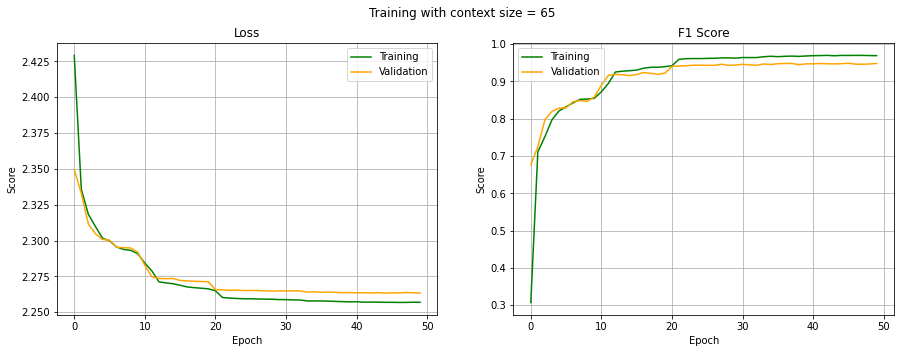

In [22]:
now = datetime.now(pytz.timezone("Asia/Ujung_Pandang"))
path_name = now.strftime("%m-%d-%Y_%H-%M-%S")
root_path = f"../../../logs/classifier/{hyperparams.context_size}_contexts/fold_0{hyperparams.fold}/{path_name}"
os.makedirs(root_path)

def looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric, n_epoch=hyperparams.n_epoch, patience=hyperparams.patience, monitor="loss"):    
    start_time = time()
    
    epoch_training_losses = []
    epoch_training_metric_scores = []
    epoch_val_losses = []
    epoch_val_metric_scores = []
    patience_counter = 0
    
    # Hyperparameters
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write(f"HYPERPARAMETERS\n")
        f.write(f"{'-' * 80}\n")
        for name, value in vars(hyperparams).items():
            f.write(f"{name}: {value}\n")
        
        f.write("\n\nTRAINING PROGRESS\n")
        f.write(f"{'-' * 80}\n")
    
    # Training Progress
    for epoch in range(1, n_epoch + 1):
        print(f"EPOCH-{epoch}")
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"EPOCH-{epoch}\n")
            f.write(f"Training Step\n")
            
        # Training Step
        print("Training Step")
        batch_training_losses, batch_training_metric_scores = training_step(train_dataloader, model, optimizer, criterion, train_metric, scheduler=None)
        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))

        epoch_training_loss = torch.mean(torch.FloatTensor(batch_training_losses))
        epoch_training_losses.append(epoch_training_loss.item())

        epoch_training_metric_score = torch.mean(torch.FloatTensor(batch_training_metric_scores))
        epoch_training_metric_scores.append(epoch_training_metric_score.item())
        
        # Validation Step
        with open(f"{root_path}/training_history.txt", "a") as f:
            f.write(f"\nValidation Step\n")
            
        print("\nValidation Step")
        batch_val_losses, batch_val_metric_scores = validation_step(val_dataloader, model, criterion, val_metric)
        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))

        epoch_val_loss = torch.mean(torch.FloatTensor(batch_val_losses))
        epoch_val_losses.append(epoch_val_loss.item())

        epoch_val_metric_score = torch.mean(torch.FloatTensor(batch_val_metric_scores))
        epoch_val_metric_scores.append(epoch_val_metric_score.item())
        
        with open(f"{root_path}/training_history.txt", "a") as f:
            if monitor == "loss":
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_losses[-1] < epoch_training_losses[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
            else:
                if epoch == 1:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                elif epoch_training_metric_scores[-1] > epoch_training_metric_scores[-2]:
                    best_state_dict = model.state_dict()
                    best_training_loss = epoch_training_loss
                    best_training_metric = epoch_training_metric_score
                    best_val_loss = epoch_val_loss
                    best_val_metric = epoch_val_metric_score
                    
                    print("\nYeah 🎉😄! Model improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    
                    f.write("\nYeah 🎉😄! Model improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                else:
                    patience_counter += 1
                    
                    print("\nHuft 😥! Model not improved.")
                    print(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}")
                    print(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}")
                    print(f"Patience = {patience_counter}/{patience}❗\n")
                    
                    f.write("\nHuft 😥! Model not improved.\n")
                    f.write(f"\nTraining   : Mean {str(criterion).split('(')[0]} = {(epoch_training_loss):.4f} | Mean {str(train_metric).split('(')[0]} = {(epoch_training_metric_score):.4f}\n")
                    f.write(f"Validation : Mean {str(criterion).split('(')[0]} = {(epoch_val_loss):.4f} | Mean {str(val_metric).split('(')[0]} = {(epoch_val_metric_score):.4f}\n")
                    f.write(f"Patience = {patience_counter}/{patience}❗\n")
                    
            print("=" * 80, end="\n\n")
            
            f.write(f"{'=' * 80}\n\n")
            
            if patience_counter == patience:
                print(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                
                f.write(f"Early stopping, patience = {patience_counter}/{patience}❗\n")
                break
        
        train_metric.reset()
        val_metric.reset()
        
    finish_time = time()
    
    # Training plot 
    fig, (ax_loss, ax_metric_score) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

    fig.suptitle(f"Training with context size = {hyperparams.context_size}")

    ax_loss.set_title("Loss")
    ax_loss.set_xlabel("Epoch")
    ax_loss.set_ylabel("Score")
    ax_loss.plot(epoch_training_losses, "green", label="Training")
    ax_loss.plot(epoch_val_losses, "orange", label="Validation")
    ax_loss.legend()
    ax_loss.grid()

    ax_metric_score.set_title("F1 Score")
    ax_metric_score.set_xlabel("Epoch")
    ax_metric_score.set_ylabel("Score")
    ax_metric_score.plot(epoch_training_metric_scores, "green", label="Training")
    ax_metric_score.plot(epoch_val_metric_scores, "orange", label="Validation")
    ax_metric_score.legend()
    ax_metric_score.grid()

    plt.savefig(f"{root_path}/training_plot.jpg", dpi=200)                        
    
    print("TRAINING SUMMARY")
    name_best_training_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_training_metric = f"Best {str(train_metric).split('(')[0]} validation".ljust(34)
    name_best_validation_loss = f"Best {str(criterion).split('(')[0]} training".ljust(34)
    name_best_validation_metric = f"Best {str(val_metric).split('(')[0]} validation".ljust(34)
    name_training_time = f"Training duration".ljust(34)
    name_training_date = f"Training date".ljust(34)
    
    print(f"{name_best_training_loss}: {best_training_loss:.4f}")
    print(f"{name_best_validation_loss}: {best_val_loss:.4f}")
    print(f"{name_best_training_metric}: {best_training_metric:.4f}")
    print(f"{name_best_validation_metric}: {best_val_metric:.4f}")
    print(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.")
    print(f"{name_training_date}: {now}")
    
    with open(f"{root_path}/training_history.txt", "a") as f:
        f.write("\nTRAINING SUMMARY\n")
        f.write(f"{'-' * 80}\n")
        f.write(f"{name_best_training_loss}: {best_training_loss:.4f}\n")
        f.write(f"{name_best_validation_loss}: {best_val_loss:.4f}\n")
        f.write(f"{name_best_training_metric}: {best_training_metric:.4f}\n")
        f.write(f"{name_best_validation_metric}: {best_val_metric:.4f}\n")
        f.write(f"{name_training_time}: {((finish_time - start_time) / 60):.4f} minutes.\n")
        f.write(f"{name_training_date}: {now}\n")
    
    # Save epoch losses, epoch metric scores, model, state dict, and oov embedding dict
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_training_losses
    }).to_csv(f"{root_path}/training_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_training_metric_scores
    }).to_csv(f"{root_path}/training_metric_scores.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "loss": epoch_val_losses
    }).to_csv(f"{root_path}/val_losses.csv", index=False)
    
    pd.DataFrame({
        "epoch": list(range(1, hyperparams.n_epoch + 1)),
        "f1_score": epoch_val_metric_scores
    }).to_csv(f"{root_path}/val_metric_scores.csv", index=False)    
    
    filename_model_params = f"{root_path}/model_params.pth"
    torch.save(best_state_dict, filename_model_params)
    
    return epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores

epoch_training_losses, epoch_training_metric_scores, epoch_val_losses, epoch_val_metric_scores = looping_step(train_dataloader, val_dataloader, model, optimizer, criterion, train_metric, val_metric)

## End Training

# Evaluation

In [23]:
def evaluation(dataloader, model, criterion, metric):
    model.eval()
    
    with torch.inference_mode():
        for batch, (feature, actual_label) in enumerate(tqdm(dataloader), 1):
            # Forward Propagation
            feature = rearrange(feature, "n s -> s n")
            actual_label = rearrange(actual_label, "n s -> s n")
            embedding = word_embeddings(feature)

            prob = model(
                embedding.to(hyperparams.device),
                actual_label.to(hyperparams.device)
            )

            prob = prob.reshape(-1, prob.shape[-1])
            actual_label = actual_label.reshape(-1)
            pred = rearrange(prob.argmax(dim=1).reshape(feature.shape[0], len(dataloader.dataset)), "s n -> n s")

            loss = criterion(prob, actual_label.to(hyperparams.device))
            metric_score = metric(prob.argmax(dim=1), actual_label.to(hyperparams.device))
            metric_score = metric.compute()

    return loss, metric_score, pred

train_dataloader = DataLoader(train_dataset, batch_size=len(train_dataset))
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset))
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset))

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
train_loss, train_f1_score, train_pred_label = evaluation(train_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
val_loss, val_f1_score, val_pred_label = evaluation(val_dataloader, model, criterion, metric)

criterion = nn.CrossEntropyLoss().to(hyperparams.device)
metric = MulticlassF1Score(average="micro", num_classes=24, mdmc_average="samplewise", multiclass=True, ignore_index=label_to_idx["<PAD>"]).to(hyperparams.device)
test_loss, test_f1_score, test_pred_label = evaluation(test_dataloader, model, criterion, metric)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [24]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9699, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9447, device='cuda:0'))

In [25]:
train_f1_score, val_f1_score, test_f1_score

(tensor(0.9699, device='cuda:0'),
 tensor(0.9491, device='cuda:0'),
 tensor(0.9447, device='cuda:0'))

## Heatmap

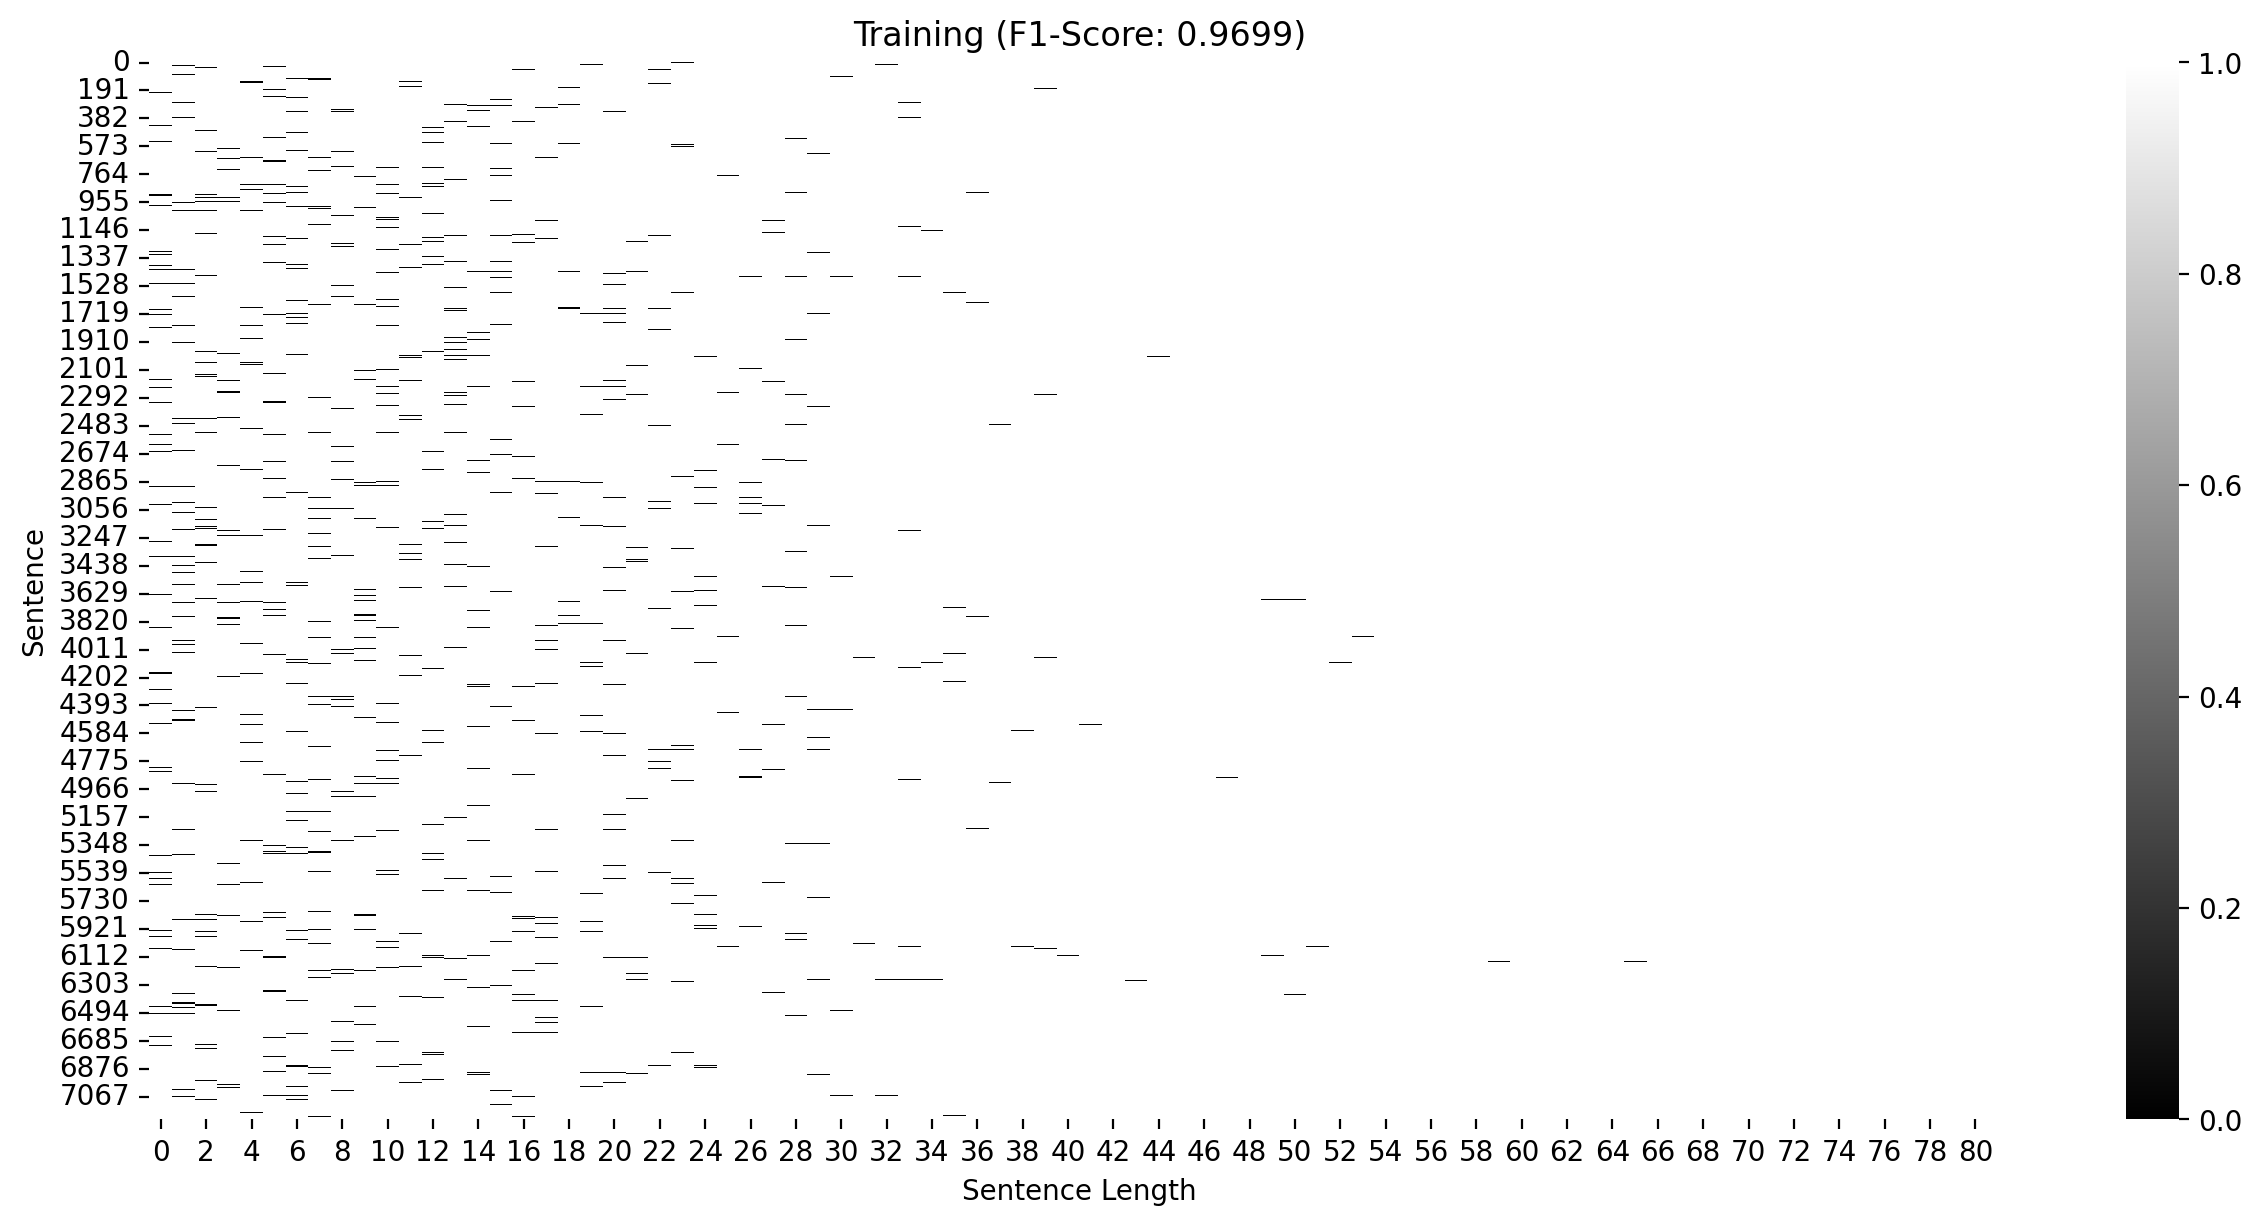

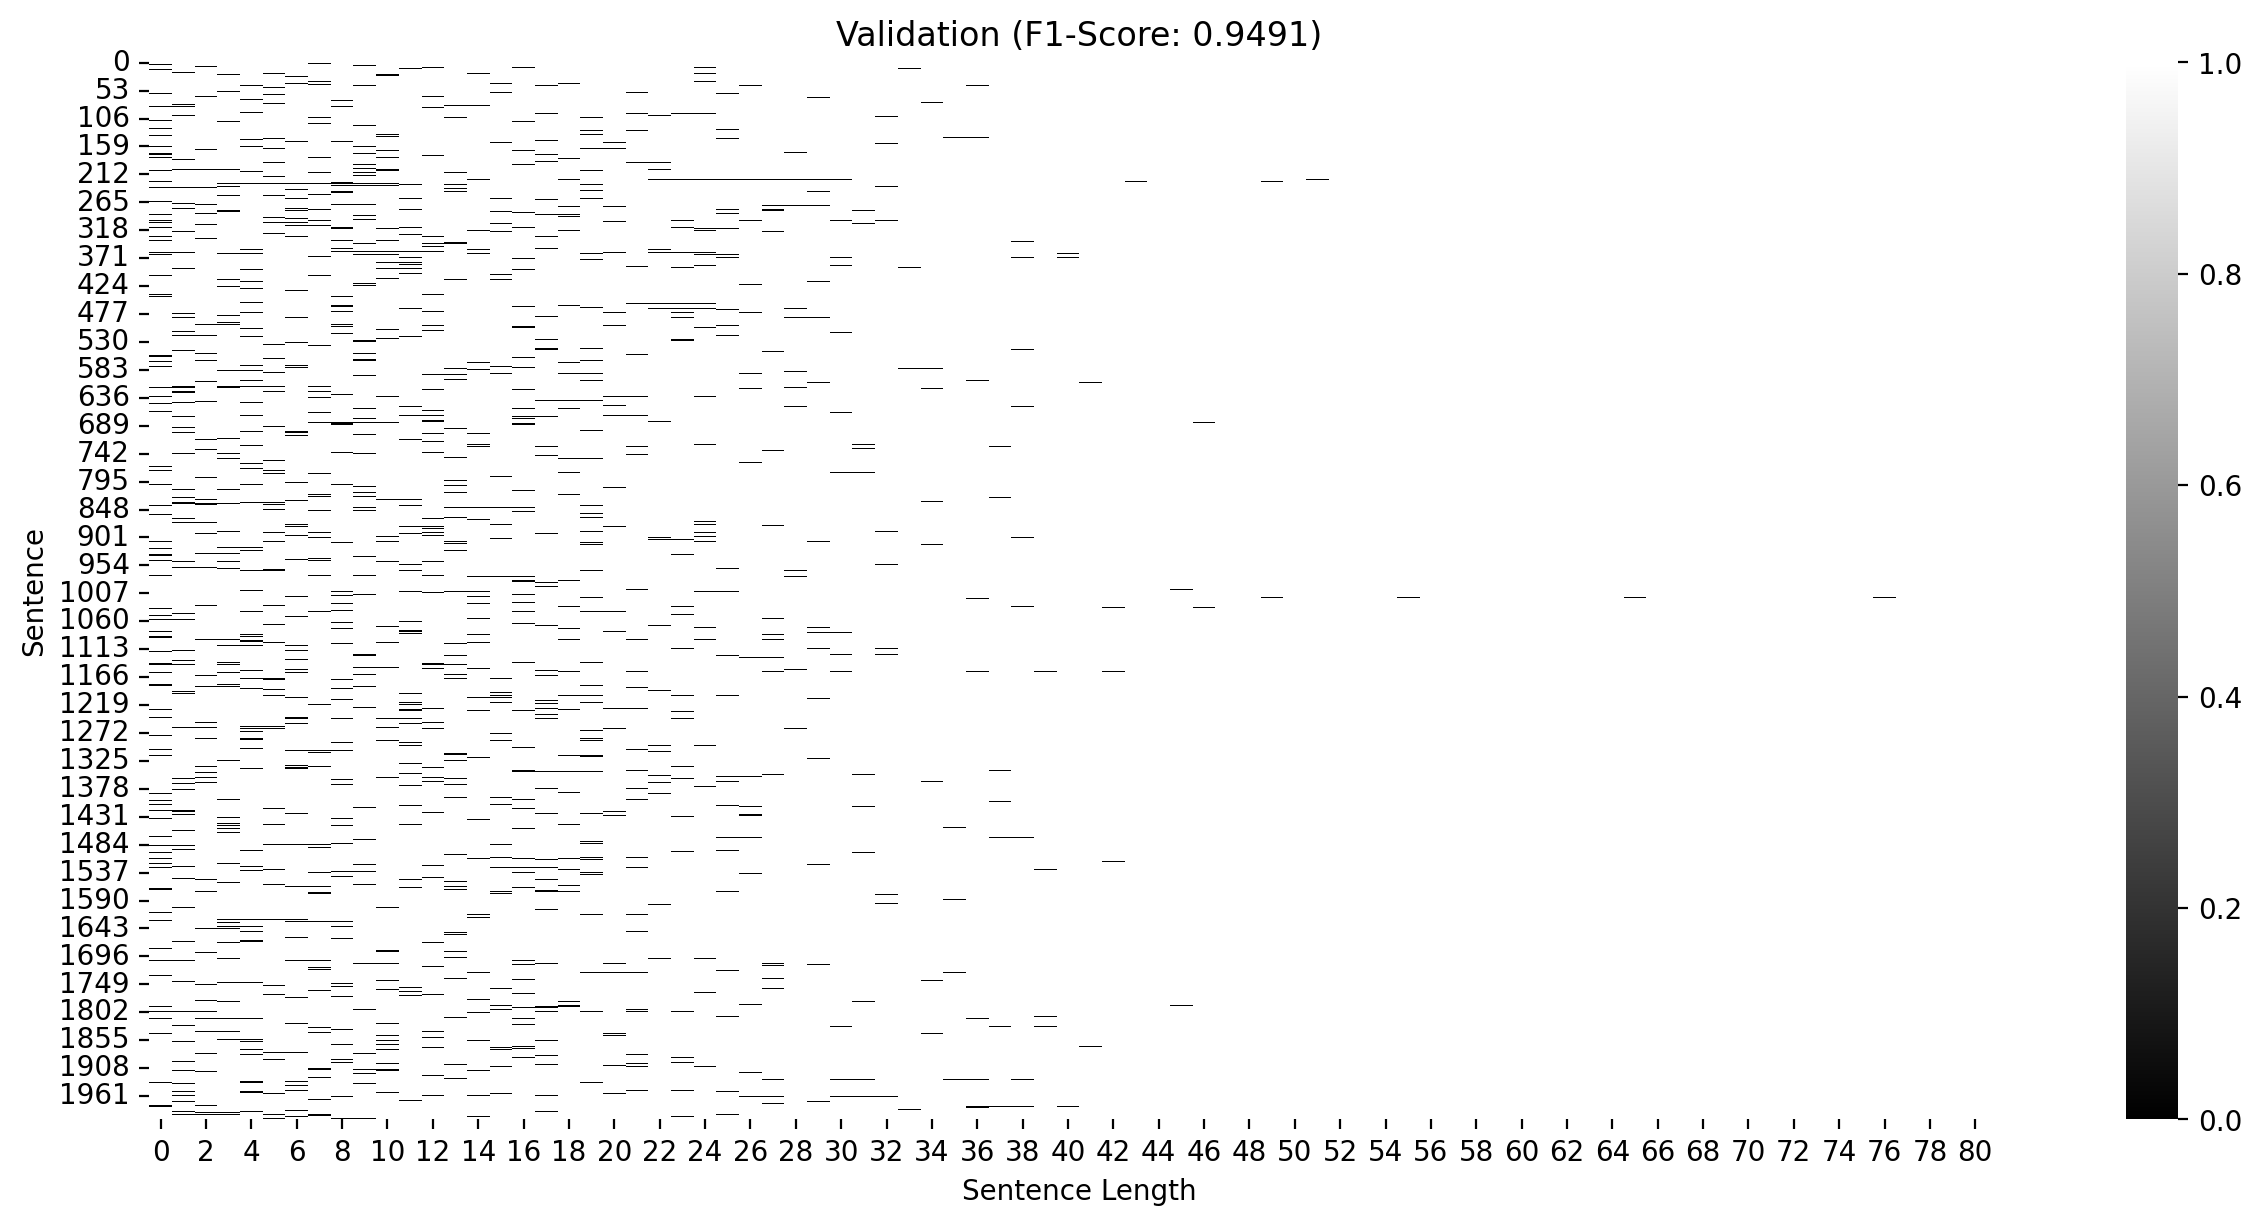

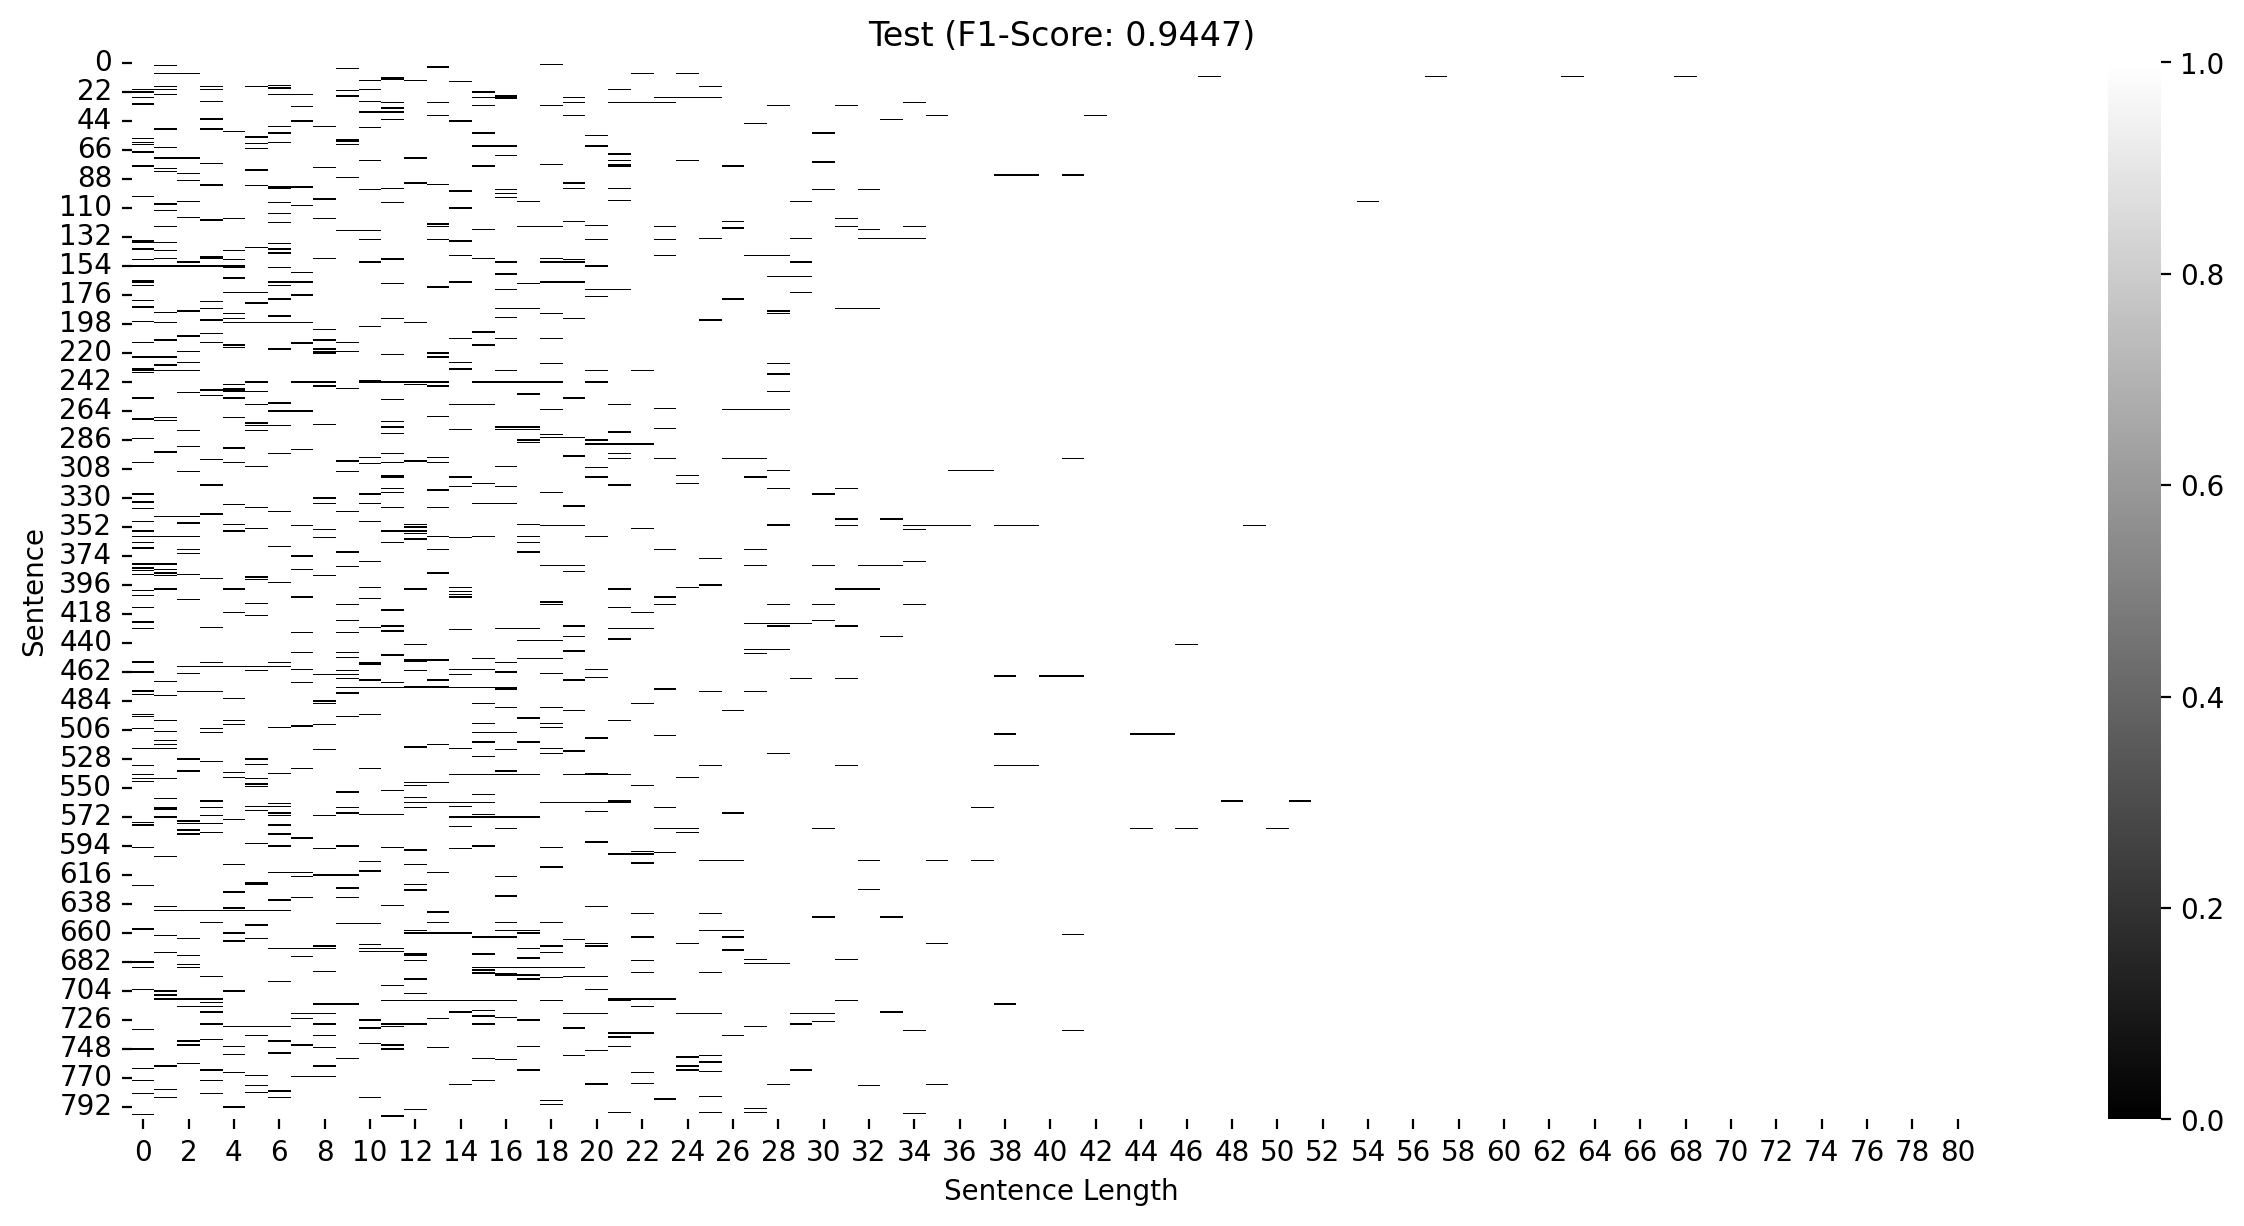

In [26]:
import seaborn as sns

def viz_evaluation(pred_label, actual_label, title):
    plt.figure(figsize=(15, 7), dpi=200)
    sns.heatmap(pred_label.detach().cpu() == actual_label, cbar=True, cmap="binary_r")
    plt.xlabel("Sentence Length")
    plt.ylabel("Sentence")
    plt.title(title)
    plt.savefig(f"{root_path}/heatmap_{title.lower()}.jpg", dpi=200)
    plt.show()

train_actual_label = train_dataloader.dataset.tensors[1]
val_actual_label = val_dataloader.dataset.tensors[1]
test_actual_label = test_dataloader.dataset.tensors[1]

viz_evaluation(train_pred_label, train_actual_label, f"Training (F1-Score: {(train_f1_score):.4f})")
viz_evaluation(val_pred_label, val_actual_label, f"Validation (F1-Score: {(val_f1_score):.4f})")
viz_evaluation(test_pred_label, test_actual_label, f"Test (F1-Score: {(test_f1_score):.4f})")

## Confusion Matrix

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 120 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)
/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: 144 NaN values found in confusion matrix have been replaced with zeros.
  warnings.warn(*args, **kwargs)


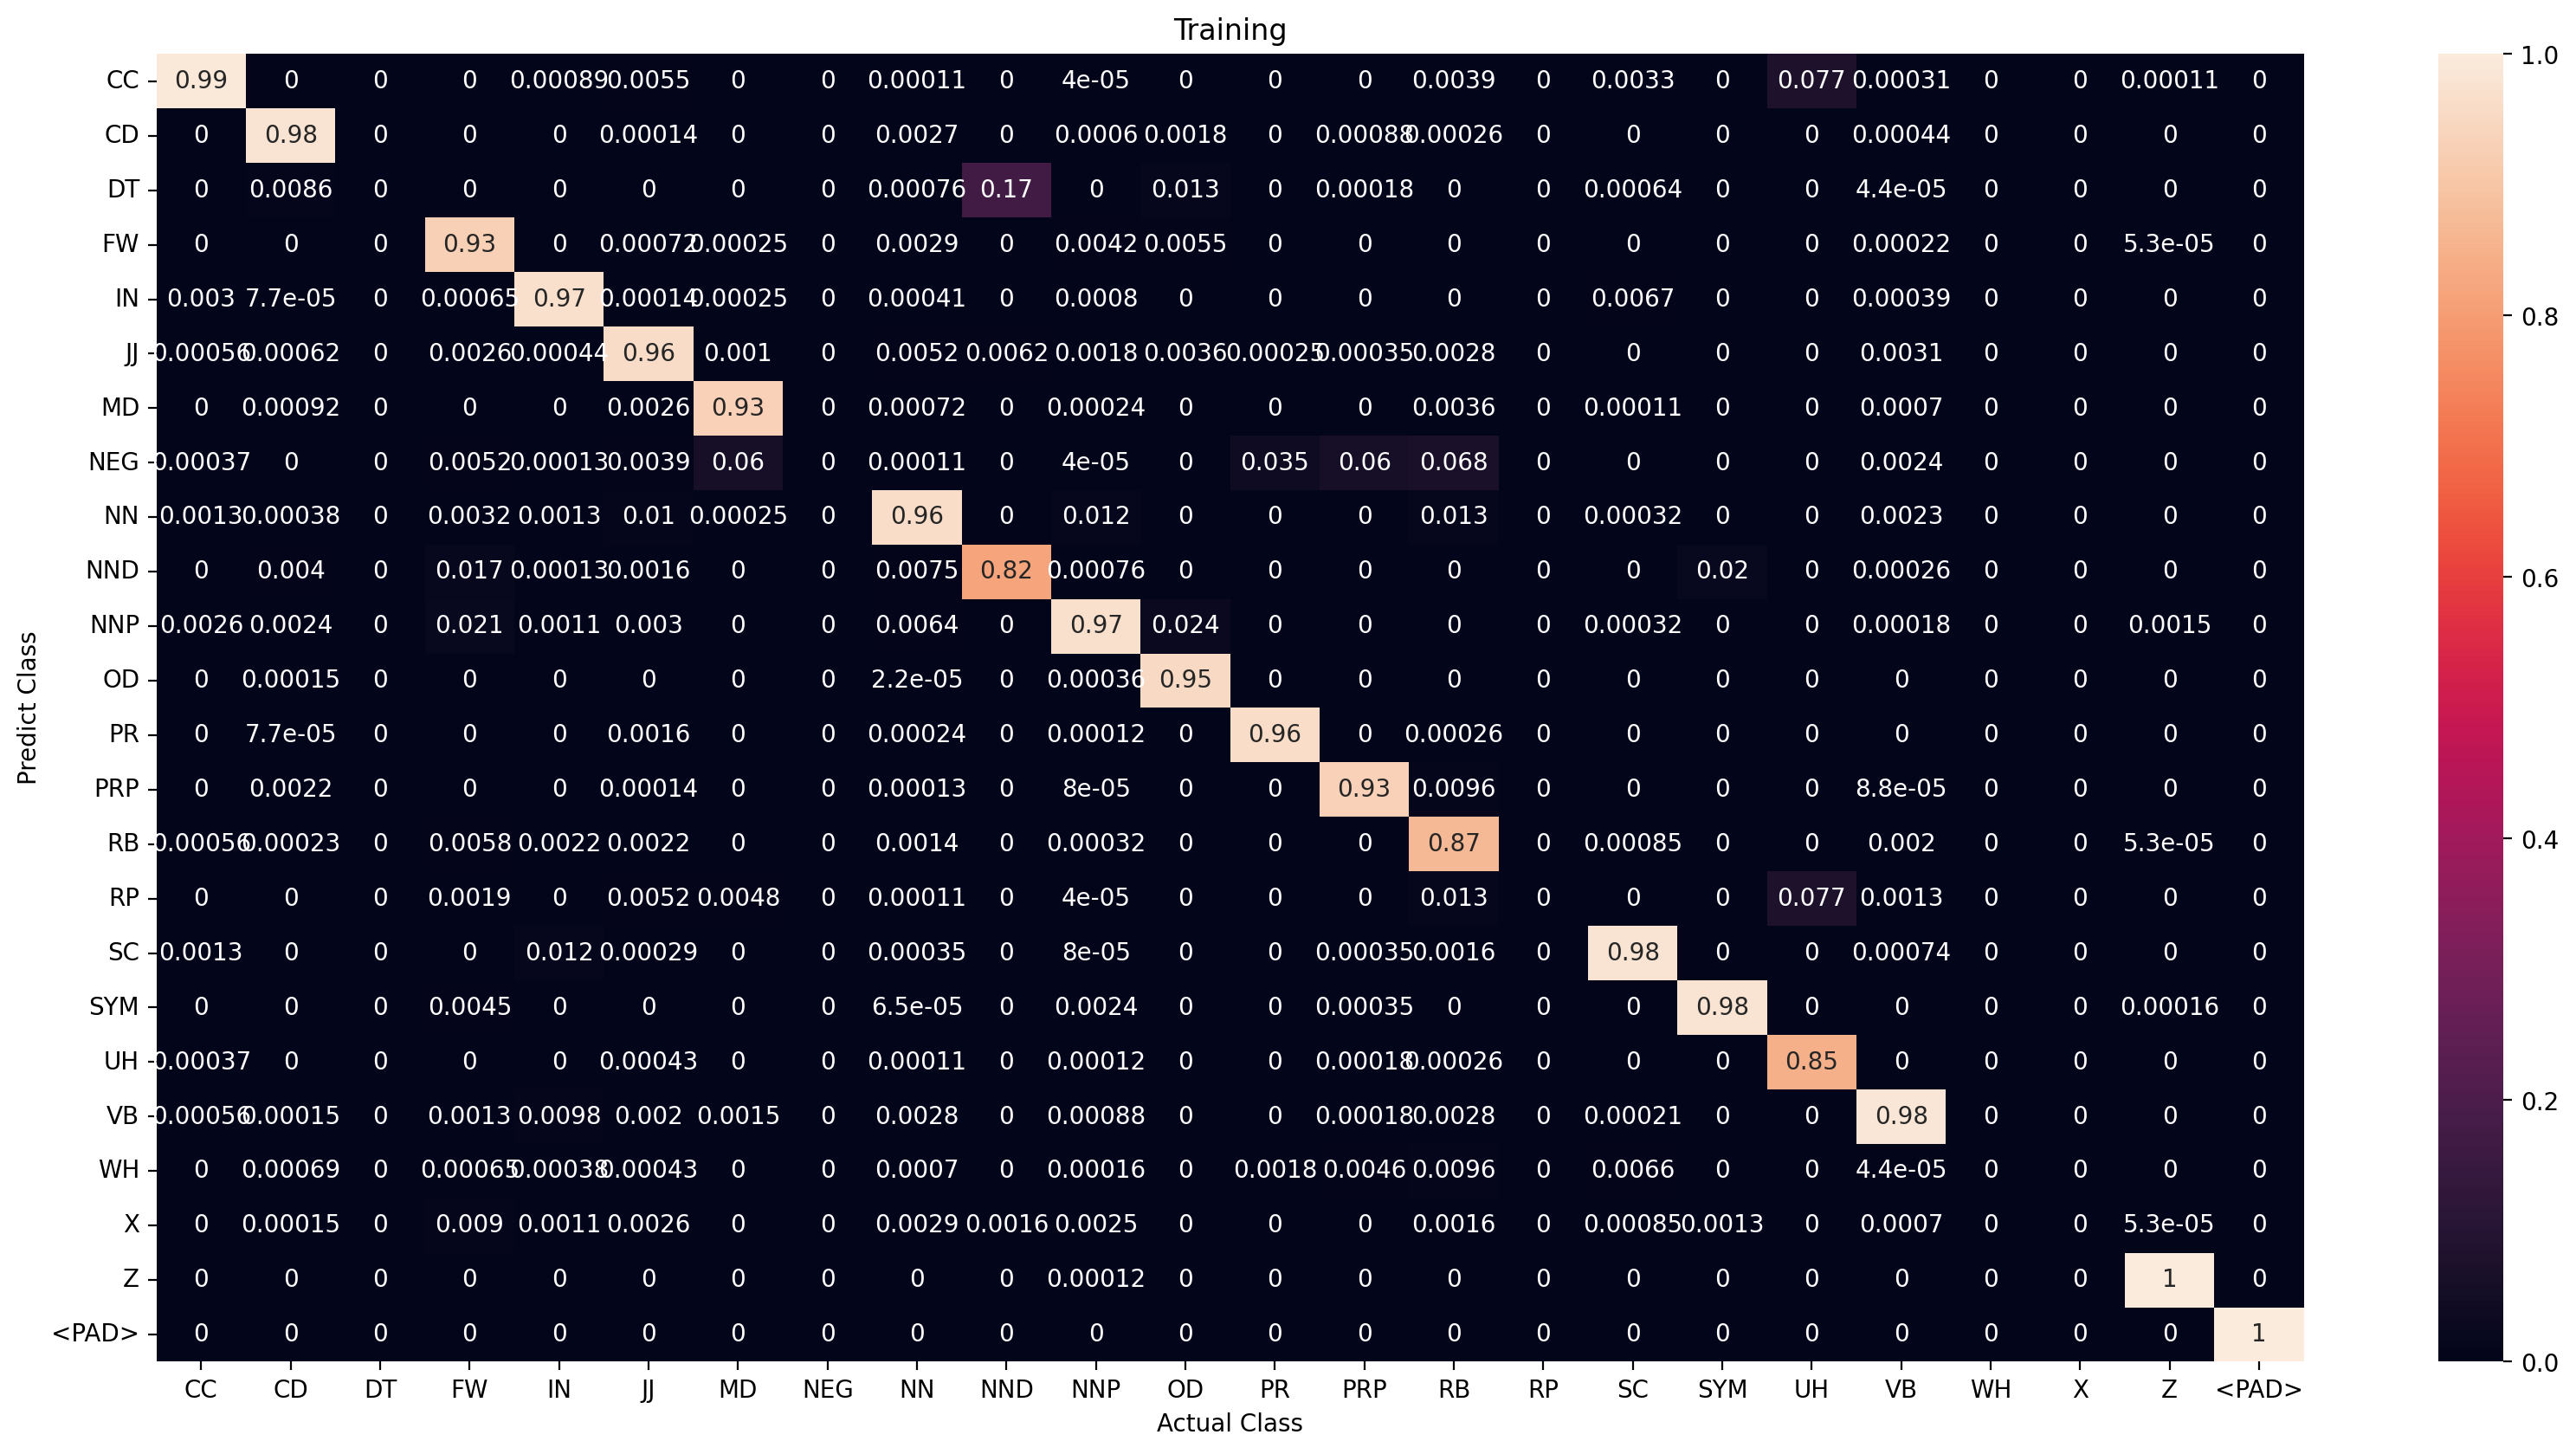

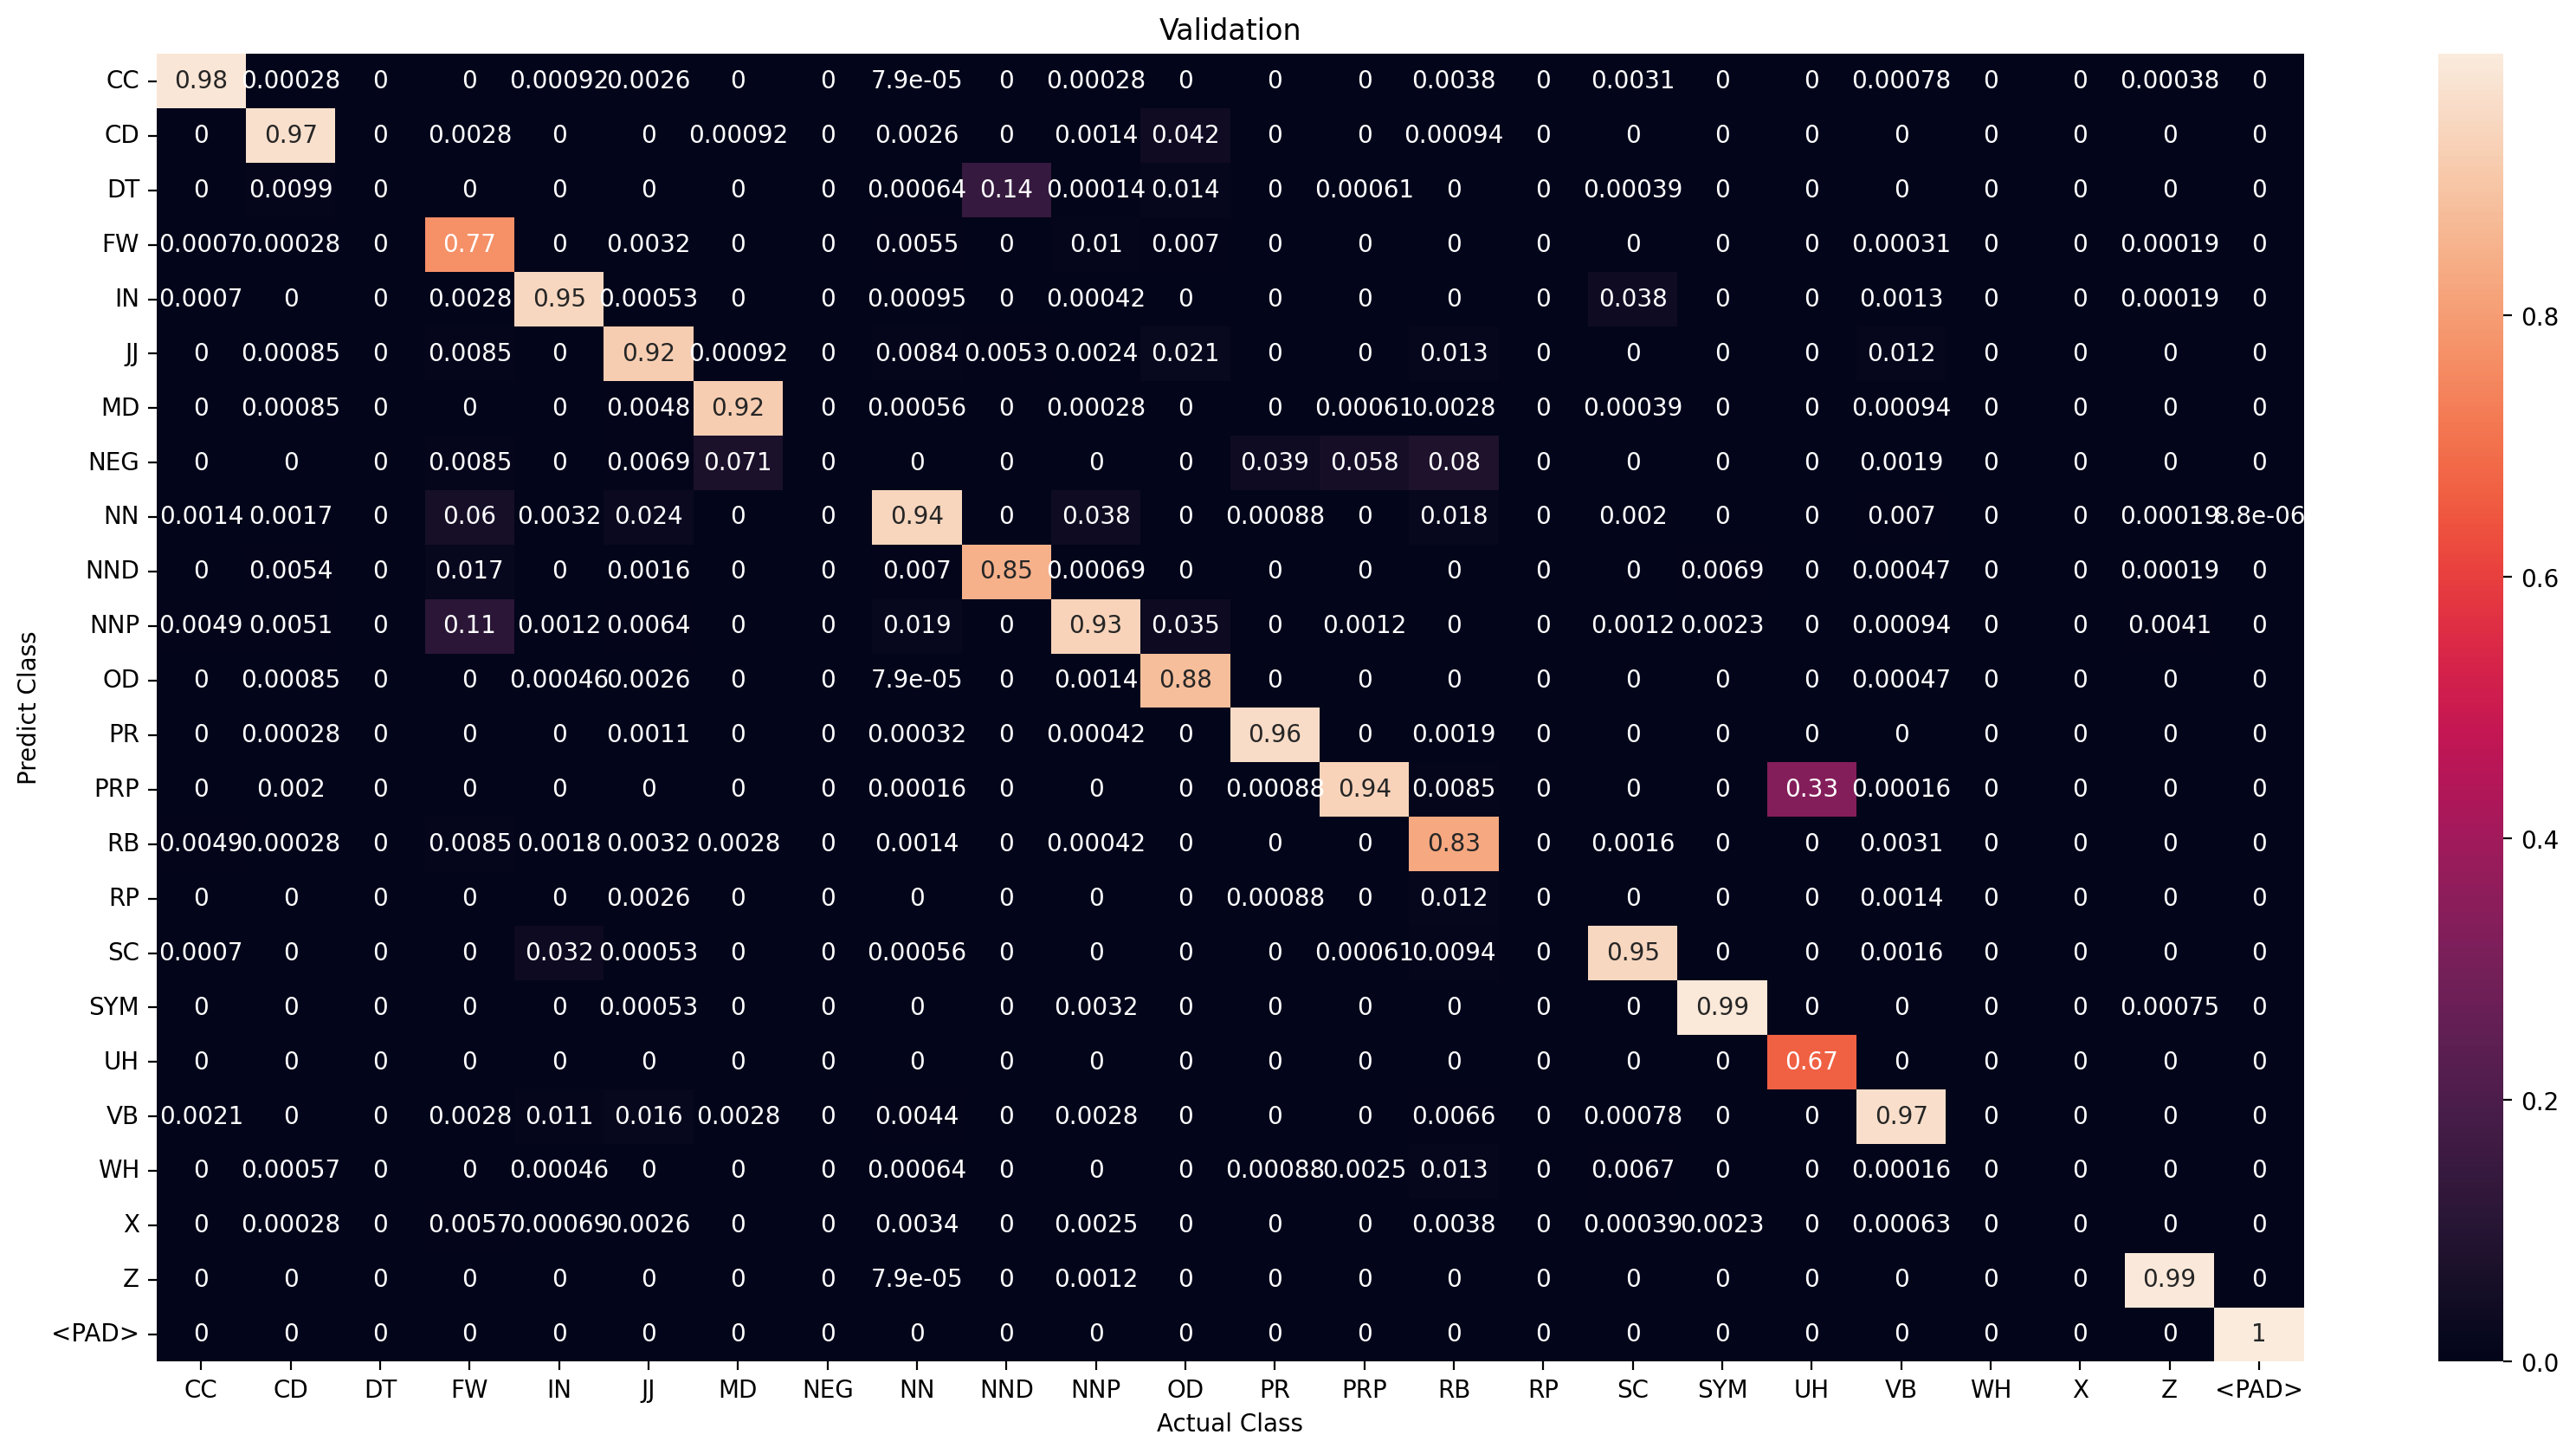

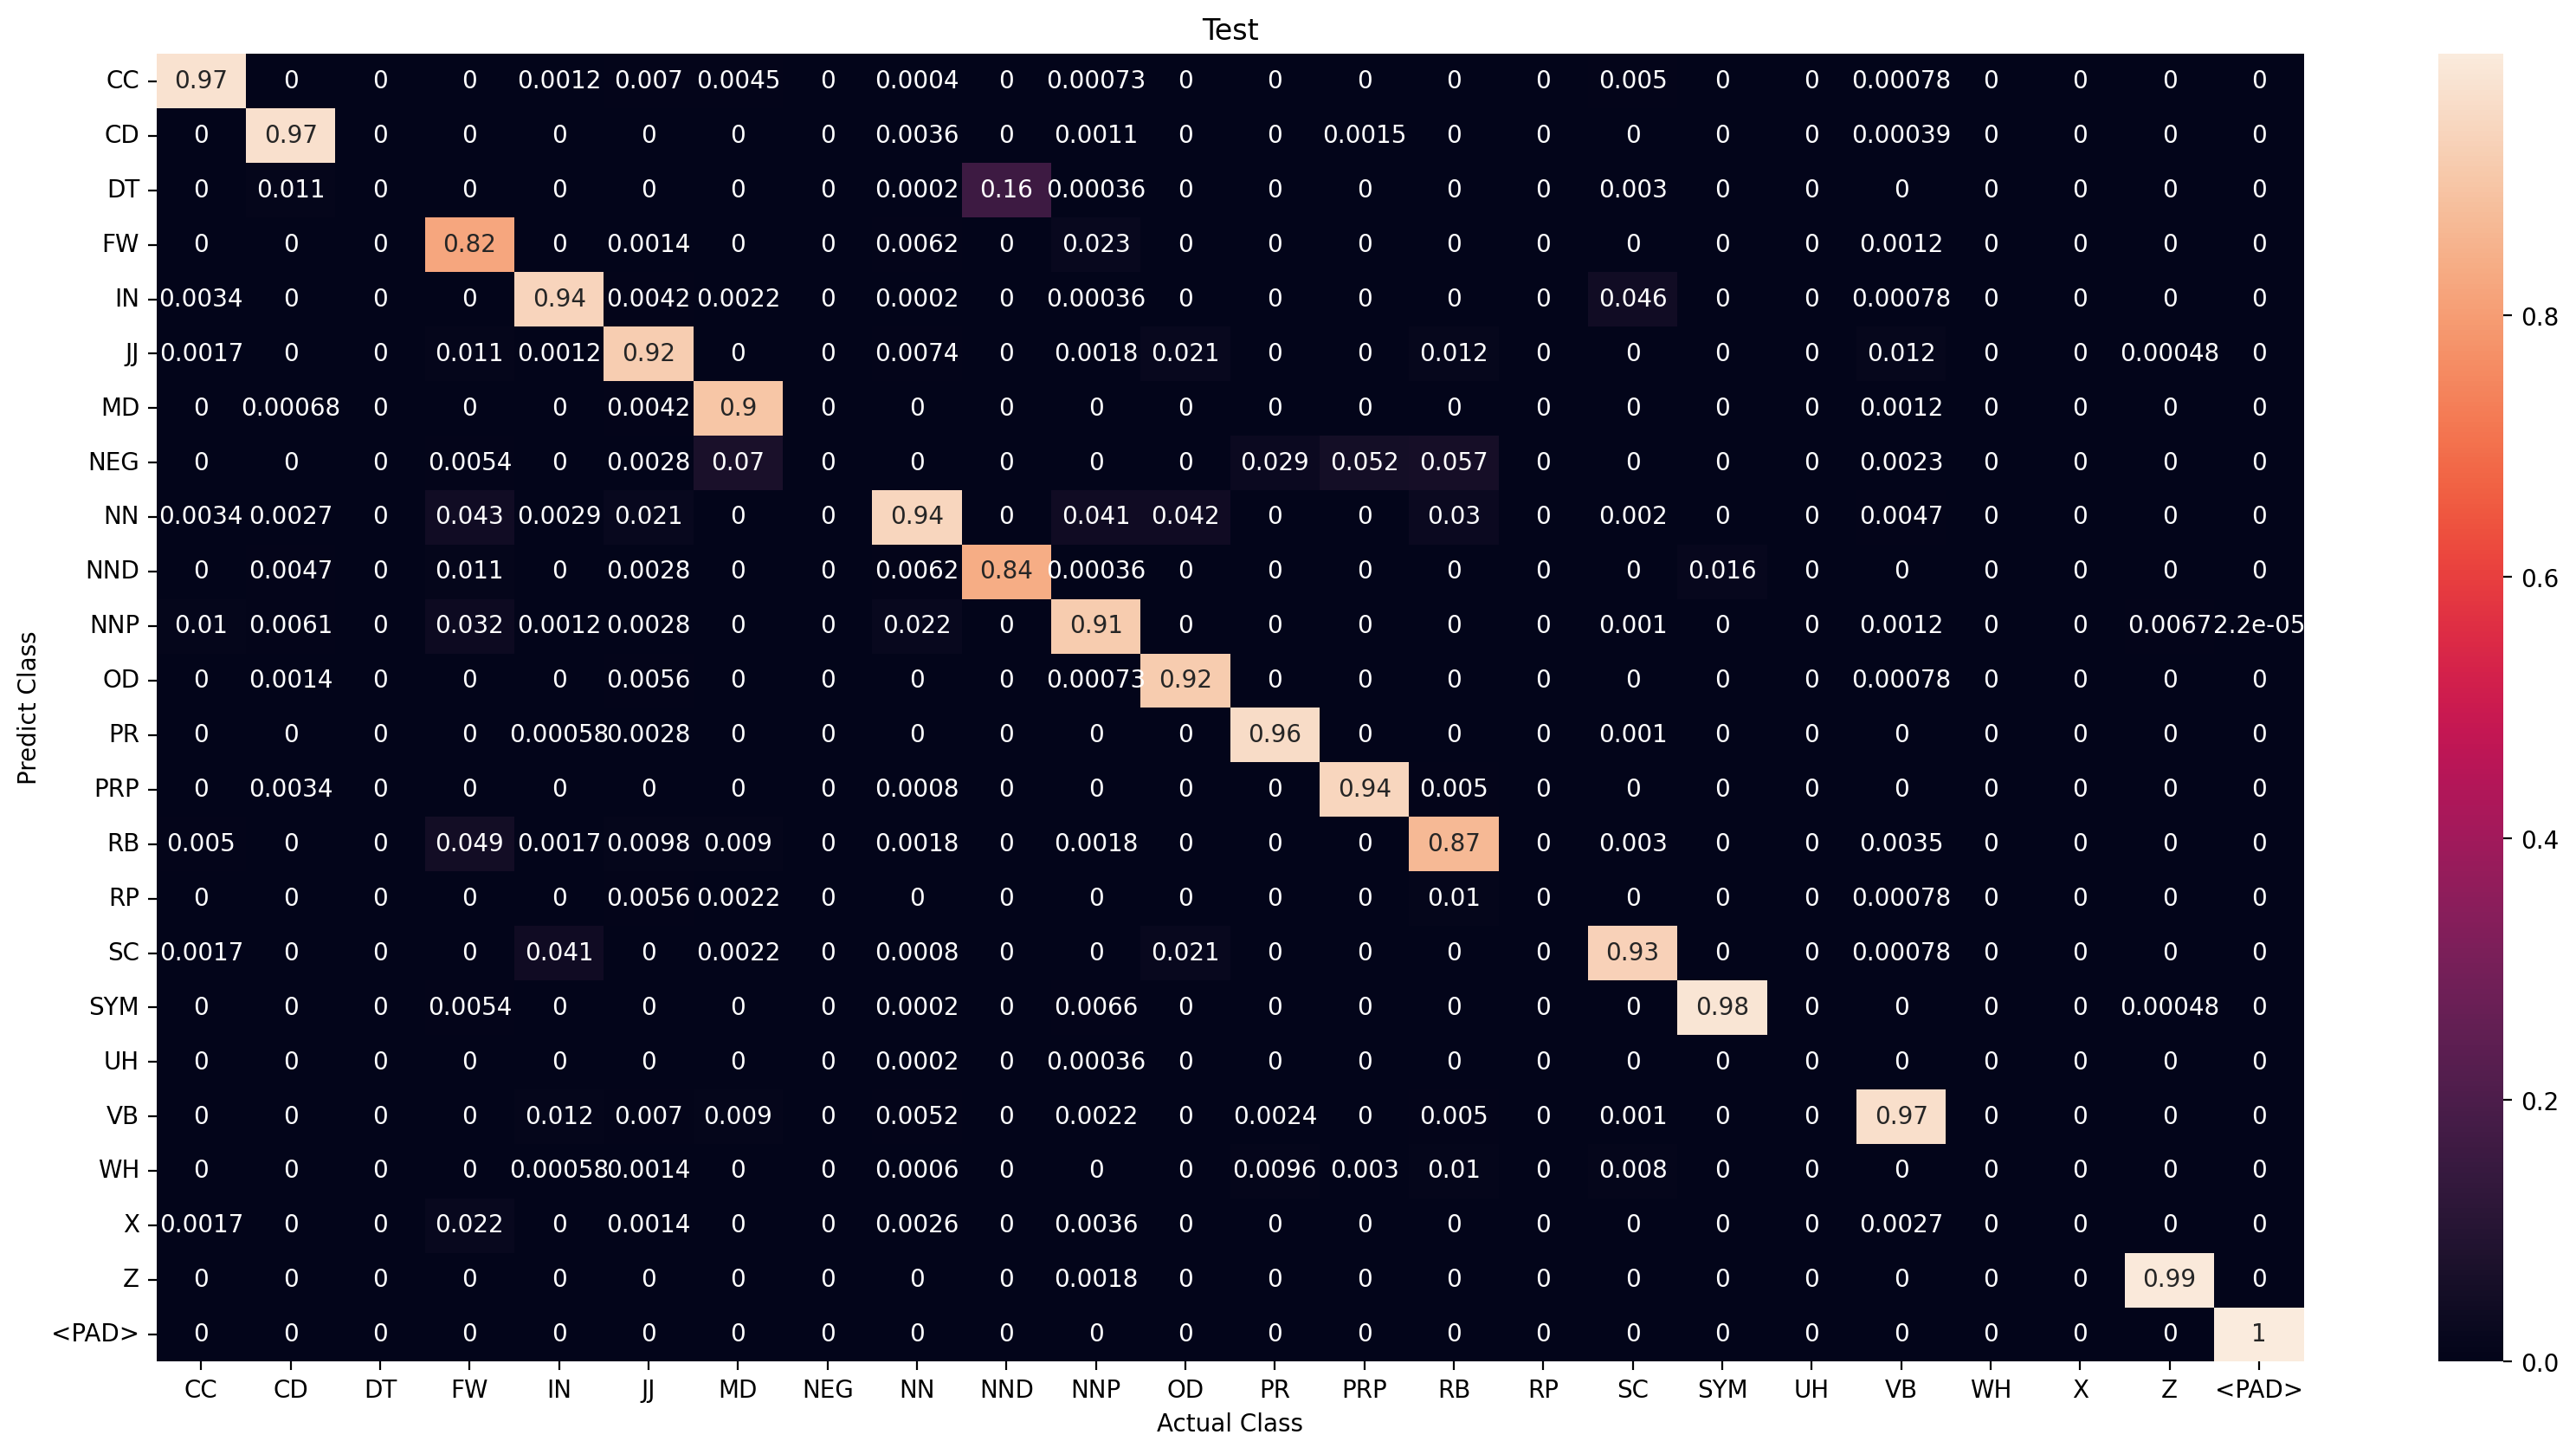

In [27]:
def confusion_matrix(pred_class, actual_class, title, normalize=None):
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize=normalize)
    plt.figure(figsize=(20, 10), dpi=200)
    sns.heatmap(conf_mat(pred_class.detach().cpu(), actual_class), annot=True, fmt=".2g", xticklabels=list(label_to_idx.keys()), yticklabels=list(label_to_idx.keys()));
    plt.yticks(rotation=0)
    plt.title(title)
    plt.xlabel("Actual Class")
    plt.ylabel("Predict Class")
    plt.savefig(f"{root_path}/conf_matrix_{title.lower()}.jpg", dpi=200)

confusion_matrix(train_pred_label, train_actual_label, "Training", "pred")
confusion_matrix(val_pred_label,val_actual_label, "Validation", "pred")
confusion_matrix(test_pred_label, test_actual_label, "Test", "pred")

## Prediction Table

In [28]:
def number_wrong_pred_each_class(pred_class, actual_class):
    classes, count_class = actual_class.flatten().unique(return_counts=True)
    conf_mat = MulticlassConfusionMatrix(num_classes=24, normalize="none")
    correct_pred_count_class = conf_mat(pred_class.detach().cpu(), actual_class).diag()
    
    correct_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (correct_pred_count_class))}
    wrong_pred = {idx_to_label[label.item()]: count.item() for label, count in zip(classes, (count_class - correct_pred_count_class))}
    
    return correct_pred, wrong_pred

correct_pred, wrong_pred = number_wrong_pred_each_class(train_pred_label, train_actual_label)
print(f"| {'Number class'.ljust(14)} | {'Correct prediction'.ljust(12)} | {'Wrong prediction'.ljust(12)} |")
for (label_correct_pred, count_correct_pred), (label_wrong_pred, count_wrong_pred) in zip(correct_pred.items(), wrong_pred.items()):
    print(f"| {str(label_correct_pred).ljust(6)}: {str(count_correct_pred + count_wrong_pred).ljust(7)}| {label_correct_pred.ljust(6)}: {str(count_correct_pred).ljust(10)} | {label_wrong_pred.ljust(6)}: {str(count_wrong_pred).ljust(8)} |")

| Number class   | Correct prediction | Wrong prediction |
| CC    : 5391   | CC    : 5277       | CC    : 114      |
| CD    : 12882  | CD    : 12727      | CD    : 155      |
| DT    : 273    | DT    : 0          | DT    : 273      |
| FW    : 1690   | FW    : 1437       | FW    : 253      |
| IN    : 15403  | IN    : 15272      | IN    : 131      |
| JJ    : 7018   | JJ    : 6618       | JJ    : 400      |
| MD    : 3810   | MD    : 3710       | MD    : 100      |
| NEG   : 1082   | NEG   : 0          | NEG   : 1082     |
| NN    : 44728  | NN    : 44211      | NN    : 517      |
| NND   : 1019   | NND   : 529        | NND   : 490      |
| NNP   : 24885  | NNP   : 24425      | NNP   : 460      |
| OD    : 534    | OD    : 522        | OD    : 12       |
| PR    : 3842   | PR    : 3815       | PR    : 27       |
| PRP   : 5405   | PRP   : 5329       | PRP   : 76       |
| RB    : 3553   | RB    : 3362       | RB    : 191      |
| RP    : 144    | RP    : 0          | RP    : 144     

In [29]:
train_actual_label[308], train_pred_label[308]

(tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23]),
 tensor([ 8, 19, 22, 10, 22, 19, 10,  6, 19,  4,  1,  8, 16, 19,  8, 19,  0,  8,
          5, 16, 19, 19,  8,  8, 22, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23, 23,
         23, 23, 23, 23, 23, 23, 23, 23, 23, 23], device='cuda:0'))

In [30]:
train_actual_label[308] == train_pred_label[308].detach().cpu()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True])

## OOV prediction is correct 

In [31]:
def oov_flag_token(sentences, max_seq_len=hyperparams.max_seq_len):
    sent_copy = deepcopy(sentences)
    sent = []
    oov_flag = []
    
    for sentence in tqdm(sent_copy):
        for token in sentence:
            sent.append(token[2])
        
        for _ in range(max_seq_len- len(sentence)):
            sent.append(False)
        
        oov_flag.append(sent)
        sent = []
        
    return np.array(oov_flag)

train_oov_flag = oov_flag_token(train_sentences, max_seq_len=hyperparams.max_seq_len)
val_oov_flag = oov_flag_token(val_sentences, max_seq_len=hyperparams.max_seq_len)
test_oov_flag = oov_flag_token(test_sentences, max_seq_len=hyperparams.max_seq_len)

def pencentage_oov_pred_correct(pred_oov_flag, oov_flag_tensor):
    oov_correct_counter = 0
    oov_wrong_counter = 0

    for pred, oov_label in tqdm(zip(pred_oov_flag, oov_flag_tensor)):
        if pred == True and oov_label == True:
            oov_correct_counter += 1
        elif pred == False and oov_label == True:
            oov_wrong_counter += 1
        else:
            continue
            
    return oov_correct_counter, oov_wrong_counter

train_pred_oov_flag = (train_actual_label == train_pred_label.detach().cpu()).flatten()
val_pred_oov_flag = (val_actual_label == val_pred_label.detach().cpu()).flatten()
test_pred_oov_flag = (test_actual_label == test_pred_label.detach().cpu()).flatten()
train_oov_flag_tensor = torch.tensor(train_oov_flag).flatten()
val_oov_flag_tensor = torch.tensor(val_oov_flag).flatten()
test_oov_flag_tensor = torch.tensor(test_oov_flag).flatten()

train_oov_correct_counter, train_oov_wrong_counter = pencentage_oov_pred_correct(train_pred_oov_flag, train_oov_flag_tensor)
val_oov_correct_counter, val_oov_wrong_counter = pencentage_oov_pred_correct(val_pred_oov_flag, val_oov_flag_tensor)
test_oov_correct_counter, test_oov_wrong_counter = pencentage_oov_pred_correct(test_pred_oov_flag, test_oov_flag_tensor)

  0%|          | 0/7222 [00:00<?, ?it/s]

  0%|          | 0/2006 [00:00<?, ?it/s]

  0%|          | 0/802 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [32]:
def print_percentage_pred_oov(title, oov_correct_counter, oov_wrong_counter):
    print(f"{title}")
    print(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}")
    print(f"Correct prediction          : {oov_correct_counter}")
    print(f"Wrong prediction            : {oov_wrong_counter}")
    print(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n")
    
    with open(f"{root_path}/oov_summary.txt", "a") as f:
        f.write(f"{title}\n")
        f.write(f"Number OOV token            : {oov_correct_counter + oov_wrong_counter}\n")
        f.write(f"Correct prediction          : {oov_correct_counter}\n")
        f.write(f"Wrong prediction            : {oov_wrong_counter}\n")
        f.write(f"Percentage correct oov pred : {oov_correct_counter / (oov_correct_counter + oov_wrong_counter) * 100}\n\n")

In [33]:
print_percentage_pred_oov("Training", train_oov_correct_counter, train_oov_wrong_counter)
print_percentage_pred_oov("Validation", val_oov_correct_counter, val_oov_wrong_counter)
print_percentage_pred_oov("Test", test_oov_correct_counter, test_oov_wrong_counter)

Training
Number OOV token            : 11808
Correct prediction          : 11001
Wrong prediction            : 807
Percentage correct oov pred : 93.16565040650406

Validation
Number OOV token            : 3395
Correct prediction          : 2998
Wrong prediction            : 397
Percentage correct oov pred : 88.30633284241532

Test
Number OOV token            : 1359
Correct prediction          : 1200
Wrong prediction            : 159
Percentage correct oov pred : 88.30022075055187



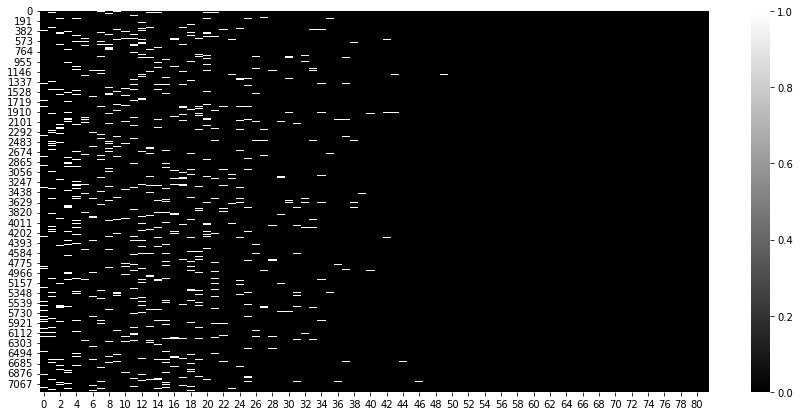

In [34]:
plt.figure(figsize=(15, 7))
sns.heatmap(train_oov_flag, cmap=plt.cm.binary_r);

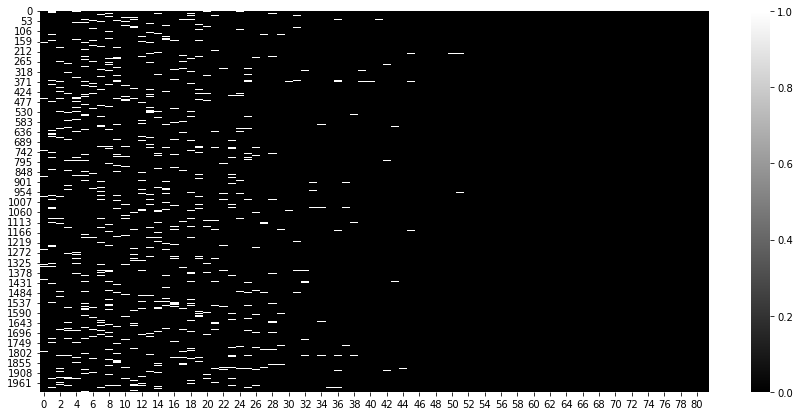

In [35]:
plt.figure(figsize=(15, 7))
sns.heatmap(val_oov_flag, cmap=plt.cm.binary_r);

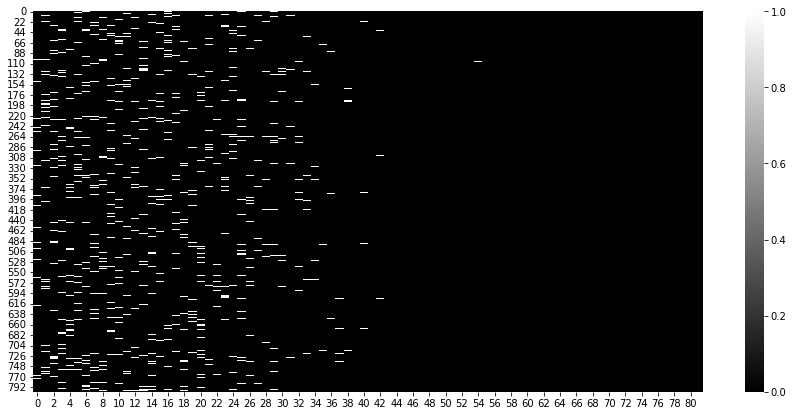

In [36]:
plt.figure(figsize=(15, 7))
sns.heatmap(test_oov_flag, cmap=plt.cm.binary_r);